In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_mask_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1079604, 410)
(1079604, 3)
validation
(190293, 410)
(190293, 3)
test
(137379, 410)
(137379, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 410)]             0         


 dense (Dense)               (None, 1024)              420864    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1110275 (4.24 MB)


Trainable params: 1110275 (4.24 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:01 - loss: 1.3223 - STD: 0.1872 - MAE: 0.4454

  2/108 [..............................] - ETA: 1:08 - loss: 1.2153 - STD: 0.1119 - MAE: 0.4448

  7/108 [>.............................] - ETA: 11s - loss: 1.1652 - STD: 0.0987 - MAE: 0.4446 

 12/108 [==>...........................] - ETA: 6s - loss: 1.1457 - STD: 0.0853 - MAE: 0.4445 

 17/108 [===>..........................] - ETA: 4s - loss: 1.1335 - STD: 0.0706 - MAE: 0.4444

 22/108 [=====>........................] - ETA: 3s - loss: 1.1269 - STD: 0.0629 - MAE: 0.4444

 27/108 [======>.......................] - ETA: 2s - loss: 1.1222 - STD: 0.0567 - MAE: 0.4443

 32/108 [=======>......................] - ETA: 2s - loss: 1.1184 - STD: 0.0507 - MAE: 0.4443

 37/108 [=========>....................] - ETA: 2s - loss: 1.1156 - STD: 0.0464 - MAE: 0.4442

 42/108 [==========>...................] - ETA: 1s - loss: 1.1131 - STD: 0.0422 - MAE: 0.4441

 47/108 [============>.................] - ETA: 1s - loss: 1.1109 - STD: 0.0388 - MAE: 0.4440

 52/108 [=============>................] - ETA: 1s - loss: 1.1089 - STD: 0.0361 - MAE: 0.4438

 57/108 [==============>...............] - ETA: 1s - loss: 1.1067 - STD: 0.0341 - MAE: 0.4436

 62/108 [================>.............] - ETA: 1s - loss: 1.1039 - STD: 0.0330 - MAE: 0.4432

 67/108 [=================>............] - ETA: 0s - loss: 1.1000 - STD: 0.0335 - MAE: 0.4424

 72/108 [===================>..........] - ETA: 0s - loss: 1.0940 - STD: 0.0361 - MAE: 0.4409

 77/108 [====================>.........] - ETA: 0s - loss: 1.0863 - STD: 0.0413 - MAE: 0.4385

 82/108 [=====================>........] - ETA: 0s - loss: 1.0780 - STD: 0.0484 - MAE: 0.4354

 87/108 [=======================>......] - ETA: 0s - loss: 1.0696 - STD: 0.0560 - MAE: 0.4320

 92/108 [========================>.....] - ETA: 0s - loss: 1.0615 - STD: 0.0628 - MAE: 0.4287

 97/108 [=========================>....] - ETA: 0s - loss: 1.0534 - STD: 0.0691 - MAE: 0.4255

102/108 [===========================>..] - ETA: 0s - loss: 1.0455 - STD: 0.0756 - MAE: 0.4222

107/108 [============================>.] - ETA: 0s - loss: 1.0379 - STD: 0.0819 - MAE: 0.4190

108/108 [==============================] - 4s 25ms/step - loss: 1.0363 - STD: 0.0831 - MAE: 0.4183 - val_loss: 0.8752 - val_STD: 0.2108 - val_MAE: 0.3472


Epoch 2/10000


  1/108 [..............................] - ETA: 3s - loss: 0.8709 - STD: 0.2097 - MAE: 0.3505

  6/108 [>.............................] - ETA: 1s - loss: 0.8677 - STD: 0.2125 - MAE: 0.3486

 11/108 [==>...........................] - ETA: 1s - loss: 0.8649 - STD: 0.2175 - MAE: 0.3458

 16/108 [===>..........................] - ETA: 1s - loss: 0.8616 - STD: 0.2198 - MAE: 0.3441

 21/108 [====>.........................] - ETA: 1s - loss: 0.8582 - STD: 0.2209 - MAE: 0.3429

 26/108 [======>.......................] - ETA: 0s - loss: 0.8583 - STD: 0.2229 - MAE: 0.3420

 31/108 [=======>......................] - ETA: 0s - loss: 0.8556 - STD: 0.2242 - MAE: 0.3408

 36/108 [=========>....................] - ETA: 0s - loss: 0.8529 - STD: 0.2253 - MAE: 0.3398

 41/108 [==========>...................] - ETA: 0s - loss: 0.8505 - STD: 0.2264 - MAE: 0.3388

 46/108 [===========>..................] - ETA: 0s - loss: 0.8484 - STD: 0.2276 - MAE: 0.3377

 51/108 [=============>................] - ETA: 0s - loss: 0.8461 - STD: 0.2289 - MAE: 0.3367

 56/108 [==============>...............] - ETA: 0s - loss: 0.8437 - STD: 0.2301 - MAE: 0.3356

 61/108 [===============>..............] - ETA: 0s - loss: 0.8417 - STD: 0.2313 - MAE: 0.3346

 66/108 [=================>............] - ETA: 0s - loss: 0.8395 - STD: 0.2325 - MAE: 0.3335

 71/108 [==================>...........] - ETA: 0s - loss: 0.8375 - STD: 0.2336 - MAE: 0.3325

 76/108 [====================>.........] - ETA: 0s - loss: 0.8356 - STD: 0.2346 - MAE: 0.3317

 81/108 [=====================>........] - ETA: 0s - loss: 0.8337 - STD: 0.2355 - MAE: 0.3308

 86/108 [======================>.......] - ETA: 0s - loss: 0.8321 - STD: 0.2363 - MAE: 0.3301

 91/108 [========================>.....] - ETA: 0s - loss: 0.8309 - STD: 0.2370 - MAE: 0.3295

 96/108 [=========================>....] - ETA: 0s - loss: 0.8295 - STD: 0.2376 - MAE: 0.3289

101/108 [===========================>..] - ETA: 0s - loss: 0.8282 - STD: 0.2383 - MAE: 0.3283

106/108 [============================>.] - ETA: 0s - loss: 0.8269 - STD: 0.2389 - MAE: 0.3278

108/108 [==============================] - 1s 13ms/step - loss: 0.8263 - STD: 0.2391 - MAE: 0.3275 - val_loss: 0.8074 - val_STD: 0.2641 - val_MAE: 0.3088


Epoch 3/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7915 - STD: 0.2562 - MAE: 0.3117

  6/108 [>.............................] - ETA: 1s - loss: 0.7904 - STD: 0.2553 - MAE: 0.3119

 11/108 [==>...........................] - ETA: 1s - loss: 0.7910 - STD: 0.2559 - MAE: 0.3118

 16/108 [===>..........................] - ETA: 1s - loss: 0.7915 - STD: 0.2555 - MAE: 0.3121

 21/108 [====>.........................] - ETA: 1s - loss: 0.7923 - STD: 0.2560 - MAE: 0.3120

 26/108 [======>.......................] - ETA: 0s - loss: 0.7921 - STD: 0.2561 - MAE: 0.3119

 31/108 [=======>......................] - ETA: 0s - loss: 0.7920 - STD: 0.2556 - MAE: 0.3122

 36/108 [=========>....................] - ETA: 0s - loss: 0.7919 - STD: 0.2557 - MAE: 0.3121

 41/108 [==========>...................] - ETA: 0s - loss: 0.7911 - STD: 0.2563 - MAE: 0.3117

 46/108 [===========>..................] - ETA: 0s - loss: 0.7905 - STD: 0.2563 - MAE: 0.3116

 51/108 [=============>................] - ETA: 0s - loss: 0.7894 - STD: 0.2567 - MAE: 0.3112

 56/108 [==============>...............] - ETA: 0s - loss: 0.7889 - STD: 0.2572 - MAE: 0.3108

 61/108 [===============>..............] - ETA: 0s - loss: 0.7885 - STD: 0.2574 - MAE: 0.3107

 66/108 [=================>............] - ETA: 0s - loss: 0.7878 - STD: 0.2576 - MAE: 0.3104

 71/108 [==================>...........] - ETA: 0s - loss: 0.7870 - STD: 0.2579 - MAE: 0.3101

 76/108 [====================>.........] - ETA: 0s - loss: 0.7862 - STD: 0.2581 - MAE: 0.3098

 81/108 [=====================>........] - ETA: 0s - loss: 0.7851 - STD: 0.2585 - MAE: 0.3095

 86/108 [======================>.......] - ETA: 0s - loss: 0.7849 - STD: 0.2590 - MAE: 0.3091

 91/108 [========================>.....] - ETA: 0s - loss: 0.7851 - STD: 0.2595 - MAE: 0.3089

 96/108 [=========================>....] - ETA: 0s - loss: 0.7844 - STD: 0.2599 - MAE: 0.3086

101/108 [===========================>..] - ETA: 0s - loss: 0.7839 - STD: 0.2601 - MAE: 0.3084

106/108 [============================>.] - ETA: 0s - loss: 0.7834 - STD: 0.2602 - MAE: 0.3082

108/108 [==============================] - 1s 13ms/step - loss: 0.7829 - STD: 0.2602 - MAE: 0.3082 - val_loss: 0.7726 - val_STD: 0.2766 - val_MAE: 0.2961


Epoch 4/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7643 - STD: 0.2652 - MAE: 0.3017

  6/108 [>.............................] - ETA: 1s - loss: 0.7680 - STD: 0.2642 - MAE: 0.3028

 11/108 [==>...........................] - ETA: 1s - loss: 0.7661 - STD: 0.2651 - MAE: 0.3020

 16/108 [===>..........................] - ETA: 1s - loss: 0.7632 - STD: 0.2659 - MAE: 0.3010

 21/108 [====>.........................] - ETA: 1s - loss: 0.7628 - STD: 0.2662 - MAE: 0.3007

 26/108 [======>.......................] - ETA: 0s - loss: 0.7622 - STD: 0.2668 - MAE: 0.3003

 31/108 [=======>......................] - ETA: 0s - loss: 0.7614 - STD: 0.2670 - MAE: 0.3000

 36/108 [=========>....................] - ETA: 0s - loss: 0.7613 - STD: 0.2673 - MAE: 0.2999

 41/108 [==========>...................] - ETA: 0s - loss: 0.7612 - STD: 0.2677 - MAE: 0.2996

 46/108 [===========>..................] - ETA: 0s - loss: 0.7604 - STD: 0.2680 - MAE: 0.2993

 51/108 [=============>................] - ETA: 0s - loss: 0.7596 - STD: 0.2684 - MAE: 0.2989

 56/108 [==============>...............] - ETA: 0s - loss: 0.7597 - STD: 0.2688 - MAE: 0.2987

 61/108 [===============>..............] - ETA: 0s - loss: 0.7592 - STD: 0.2691 - MAE: 0.2984

 66/108 [=================>............] - ETA: 0s - loss: 0.7589 - STD: 0.2693 - MAE: 0.2983

 71/108 [==================>...........] - ETA: 0s - loss: 0.7585 - STD: 0.2694 - MAE: 0.2982

 76/108 [====================>.........] - ETA: 0s - loss: 0.7585 - STD: 0.2696 - MAE: 0.2980

 81/108 [=====================>........] - ETA: 0s - loss: 0.7581 - STD: 0.2698 - MAE: 0.2978

 86/108 [======================>.......] - ETA: 0s - loss: 0.7581 - STD: 0.2699 - MAE: 0.2977

 91/108 [========================>.....] - ETA: 0s - loss: 0.7582 - STD: 0.2700 - MAE: 0.2977

 96/108 [=========================>....] - ETA: 0s - loss: 0.7582 - STD: 0.2701 - MAE: 0.2977

101/108 [===========================>..] - ETA: 0s - loss: 0.7582 - STD: 0.2703 - MAE: 0.2976

106/108 [============================>.] - ETA: 0s - loss: 0.7578 - STD: 0.2703 - MAE: 0.2975

108/108 [==============================] - 1s 13ms/step - loss: 0.7576 - STD: 0.2703 - MAE: 0.2975 - val_loss: 0.7627 - val_STD: 0.2854 - val_MAE: 0.2893


Epoch 5/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7515 - STD: 0.2735 - MAE: 0.2946

  5/108 [>.............................] - ETA: 1s - loss: 0.7468 - STD: 0.2735 - MAE: 0.2934

 10/108 [=>............................] - ETA: 1s - loss: 0.7454 - STD: 0.2748 - MAE: 0.2925

 15/108 [===>..........................] - ETA: 1s - loss: 0.7457 - STD: 0.2744 - MAE: 0.2928

 20/108 [====>.........................] - ETA: 1s - loss: 0.7461 - STD: 0.2743 - MAE: 0.2929

 25/108 [=====>........................] - ETA: 0s - loss: 0.7473 - STD: 0.2746 - MAE: 0.2930

 30/108 [=======>......................] - ETA: 0s - loss: 0.7480 - STD: 0.2744 - MAE: 0.2933

 35/108 [========>.....................] - ETA: 0s - loss: 0.7479 - STD: 0.2745 - MAE: 0.2932

 40/108 [==========>...................] - ETA: 0s - loss: 0.7482 - STD: 0.2745 - MAE: 0.2932

 45/108 [===========>..................] - ETA: 0s - loss: 0.7482 - STD: 0.2746 - MAE: 0.2932

 50/108 [============>.................] - ETA: 0s - loss: 0.7485 - STD: 0.2746 - MAE: 0.2932

 55/108 [==============>...............] - ETA: 0s - loss: 0.7485 - STD: 0.2747 - MAE: 0.2932

 60/108 [===============>..............] - ETA: 0s - loss: 0.7482 - STD: 0.2747 - MAE: 0.2931

 65/108 [=================>............] - ETA: 0s - loss: 0.7476 - STD: 0.2748 - MAE: 0.2929

 70/108 [==================>...........] - ETA: 0s - loss: 0.7472 - STD: 0.2749 - MAE: 0.2928

 75/108 [===================>..........] - ETA: 0s - loss: 0.7468 - STD: 0.2750 - MAE: 0.2926

 80/108 [=====================>........] - ETA: 0s - loss: 0.7464 - STD: 0.2752 - MAE: 0.2925

 85/108 [======================>.......] - ETA: 0s - loss: 0.7463 - STD: 0.2754 - MAE: 0.2923

 90/108 [========================>.....] - ETA: 0s - loss: 0.7461 - STD: 0.2755 - MAE: 0.2922

 95/108 [=========================>....] - ETA: 0s - loss: 0.7456 - STD: 0.2755 - MAE: 0.2921

100/108 [==========================>...] - ETA: 0s - loss: 0.7454 - STD: 0.2757 - MAE: 0.2920

105/108 [============================>.] - ETA: 0s - loss: 0.7453 - STD: 0.2758 - MAE: 0.2919

108/108 [==============================] - 1s 14ms/step - loss: 0.7451 - STD: 0.2759 - MAE: 0.2918 - val_loss: 0.7457 - val_STD: 0.2906 - val_MAE: 0.2815


Epoch 6/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7410 - STD: 0.2755 - MAE: 0.2912

  6/108 [>.............................] - ETA: 1s - loss: 0.7418 - STD: 0.2780 - MAE: 0.2900

 11/108 [==>...........................] - ETA: 1s - loss: 0.7491 - STD: 0.2797 - MAE: 0.2905

 16/108 [===>..........................] - ETA: 1s - loss: 0.7555 - STD: 0.2814 - MAE: 0.2909

 21/108 [====>.........................] - ETA: 1s - loss: 0.7541 - STD: 0.2802 - MAE: 0.2913

 26/108 [======>.......................] - ETA: 0s - loss: 0.7531 - STD: 0.2787 - MAE: 0.2919

 31/108 [=======>......................] - ETA: 0s - loss: 0.7516 - STD: 0.2774 - MAE: 0.2923

 36/108 [=========>....................] - ETA: 0s - loss: 0.7498 - STD: 0.2769 - MAE: 0.2922

 41/108 [==========>...................] - ETA: 0s - loss: 0.7479 - STD: 0.2766 - MAE: 0.2920

 46/108 [===========>..................] - ETA: 0s - loss: 0.7463 - STD: 0.2766 - MAE: 0.2917

 51/108 [=============>................] - ETA: 0s - loss: 0.7456 - STD: 0.2768 - MAE: 0.2914

 56/108 [==============>...............] - ETA: 0s - loss: 0.7446 - STD: 0.2770 - MAE: 0.2911

 61/108 [===============>..............] - ETA: 0s - loss: 0.7438 - STD: 0.2772 - MAE: 0.2908

 66/108 [=================>............] - ETA: 0s - loss: 0.7434 - STD: 0.2774 - MAE: 0.2906

 71/108 [==================>...........] - ETA: 0s - loss: 0.7426 - STD: 0.2776 - MAE: 0.2903

 76/108 [====================>.........] - ETA: 0s - loss: 0.7423 - STD: 0.2778 - MAE: 0.2901

 81/108 [=====================>........] - ETA: 0s - loss: 0.7415 - STD: 0.2779 - MAE: 0.2899

 86/108 [======================>.......] - ETA: 0s - loss: 0.7411 - STD: 0.2779 - MAE: 0.2898

 91/108 [========================>.....] - ETA: 0s - loss: 0.7406 - STD: 0.2781 - MAE: 0.2896

 96/108 [=========================>....] - ETA: 0s - loss: 0.7405 - STD: 0.2784 - MAE: 0.2894

101/108 [===========================>..] - ETA: 0s - loss: 0.7404 - STD: 0.2786 - MAE: 0.2893

106/108 [============================>.] - ETA: 0s - loss: 0.7402 - STD: 0.2786 - MAE: 0.2892

108/108 [==============================] - 1s 13ms/step - loss: 0.7399 - STD: 0.2786 - MAE: 0.2891 - val_loss: 0.7424 - val_STD: 0.2945 - val_MAE: 0.2787


Epoch 7/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7372 - STD: 0.2809 - MAE: 0.2875

  6/108 [>.............................] - ETA: 1s - loss: 0.7298 - STD: 0.2818 - MAE: 0.2853

 11/108 [==>...........................] - ETA: 1s - loss: 0.7325 - STD: 0.2809 - MAE: 0.2864

 16/108 [===>..........................] - ETA: 1s - loss: 0.7328 - STD: 0.2803 - MAE: 0.2867

 21/108 [====>.........................] - ETA: 1s - loss: 0.7327 - STD: 0.2803 - MAE: 0.2867

 26/108 [======>.......................] - ETA: 0s - loss: 0.7319 - STD: 0.2804 - MAE: 0.2864

 31/108 [=======>......................] - ETA: 0s - loss: 0.7311 - STD: 0.2812 - MAE: 0.2858

 36/108 [=========>....................] - ETA: 0s - loss: 0.7313 - STD: 0.2815 - MAE: 0.2857

 41/108 [==========>...................] - ETA: 0s - loss: 0.7316 - STD: 0.2813 - MAE: 0.2858

 46/108 [===========>..................] - ETA: 0s - loss: 0.7316 - STD: 0.2811 - MAE: 0.2860

 51/108 [=============>................] - ETA: 0s - loss: 0.7317 - STD: 0.2809 - MAE: 0.2861

 56/108 [==============>...............] - ETA: 0s - loss: 0.7315 - STD: 0.2810 - MAE: 0.2861

 61/108 [===============>..............] - ETA: 0s - loss: 0.7312 - STD: 0.2809 - MAE: 0.2860

 66/108 [=================>............] - ETA: 0s - loss: 0.7308 - STD: 0.2811 - MAE: 0.2858

 71/108 [==================>...........] - ETA: 0s - loss: 0.7307 - STD: 0.2813 - MAE: 0.2857

 76/108 [====================>.........] - ETA: 0s - loss: 0.7303 - STD: 0.2815 - MAE: 0.2855

 81/108 [=====================>........] - ETA: 0s - loss: 0.7299 - STD: 0.2815 - MAE: 0.2854

 86/108 [======================>.......] - ETA: 0s - loss: 0.7298 - STD: 0.2816 - MAE: 0.2854

 91/108 [========================>.....] - ETA: 0s - loss: 0.7299 - STD: 0.2816 - MAE: 0.2854

 96/108 [=========================>....] - ETA: 0s - loss: 0.7299 - STD: 0.2817 - MAE: 0.2853

101/108 [===========================>..] - ETA: 0s - loss: 0.7297 - STD: 0.2819 - MAE: 0.2852

106/108 [============================>.] - ETA: 0s - loss: 0.7299 - STD: 0.2820 - MAE: 0.2852

108/108 [==============================] - 1s 13ms/step - loss: 0.7298 - STD: 0.2820 - MAE: 0.2851 - val_loss: 0.7397 - val_STD: 0.2933 - val_MAE: 0.2786


Epoch 8/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7359 - STD: 0.2801 - MAE: 0.2877

  6/108 [>.............................] - ETA: 1s - loss: 0.7290 - STD: 0.2805 - MAE: 0.2859

 11/108 [==>...........................] - ETA: 1s - loss: 0.7293 - STD: 0.2809 - MAE: 0.2858

 16/108 [===>..........................] - ETA: 1s - loss: 0.7297 - STD: 0.2806 - MAE: 0.2860

 21/108 [====>.........................] - ETA: 1s - loss: 0.7312 - STD: 0.2814 - MAE: 0.2859

 26/108 [======>.......................] - ETA: 0s - loss: 0.7296 - STD: 0.2816 - MAE: 0.2855

 31/108 [=======>......................] - ETA: 0s - loss: 0.7297 - STD: 0.2818 - MAE: 0.2853

 36/108 [=========>....................] - ETA: 0s - loss: 0.7288 - STD: 0.2822 - MAE: 0.2849

 41/108 [==========>...................] - ETA: 0s - loss: 0.7277 - STD: 0.2827 - MAE: 0.2843

 46/108 [===========>..................] - ETA: 0s - loss: 0.7269 - STD: 0.2825 - MAE: 0.2843

 51/108 [=============>................] - ETA: 0s - loss: 0.7270 - STD: 0.2828 - MAE: 0.2841

 56/108 [==============>...............] - ETA: 0s - loss: 0.7282 - STD: 0.2831 - MAE: 0.2843

 61/108 [===============>..............] - ETA: 0s - loss: 0.7299 - STD: 0.2833 - MAE: 0.2845

 66/108 [=================>............] - ETA: 0s - loss: 0.7297 - STD: 0.2832 - MAE: 0.2845

 71/108 [==================>...........] - ETA: 0s - loss: 0.7298 - STD: 0.2832 - MAE: 0.2845

 76/108 [====================>.........] - ETA: 0s - loss: 0.7298 - STD: 0.2829 - MAE: 0.2847

 81/108 [=====================>........] - ETA: 0s - loss: 0.7292 - STD: 0.2827 - MAE: 0.2847

 86/108 [======================>.......] - ETA: 0s - loss: 0.7292 - STD: 0.2826 - MAE: 0.2847

 90/108 [========================>.....] - ETA: 0s - loss: 0.7288 - STD: 0.2827 - MAE: 0.2846

 95/108 [=========================>....] - ETA: 0s - loss: 0.7288 - STD: 0.2827 - MAE: 0.2845

100/108 [==========================>...] - ETA: 0s - loss: 0.7287 - STD: 0.2828 - MAE: 0.2845

105/108 [============================>.] - ETA: 0s - loss: 0.7284 - STD: 0.2828 - MAE: 0.2844

108/108 [==============================] - 1s 14ms/step - loss: 0.7281 - STD: 0.2827 - MAE: 0.2844 - val_loss: 0.7350 - val_STD: 0.2957 - val_MAE: 0.2767


Epoch 9/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7100 - STD: 0.2849 - MAE: 0.2797

  6/108 [>.............................] - ETA: 1s - loss: 0.7173 - STD: 0.2856 - MAE: 0.2804

 11/108 [==>...........................] - ETA: 1s - loss: 0.7170 - STD: 0.2852 - MAE: 0.2806

 16/108 [===>..........................] - ETA: 1s - loss: 0.7183 - STD: 0.2853 - MAE: 0.2808

 21/108 [====>.........................] - ETA: 1s - loss: 0.7210 - STD: 0.2853 - MAE: 0.2814

 26/108 [======>.......................] - ETA: 0s - loss: 0.7206 - STD: 0.2849 - MAE: 0.2815

 31/108 [=======>......................] - ETA: 0s - loss: 0.7210 - STD: 0.2849 - MAE: 0.2816

 36/108 [=========>....................] - ETA: 0s - loss: 0.7218 - STD: 0.2852 - MAE: 0.2816

 41/108 [==========>...................] - ETA: 0s - loss: 0.7218 - STD: 0.2851 - MAE: 0.2817

 46/108 [===========>..................] - ETA: 0s - loss: 0.7217 - STD: 0.2850 - MAE: 0.2818

 51/108 [=============>................] - ETA: 0s - loss: 0.7215 - STD: 0.2850 - MAE: 0.2817

 56/108 [==============>...............] - ETA: 0s - loss: 0.7219 - STD: 0.2851 - MAE: 0.2817

 61/108 [===============>..............] - ETA: 0s - loss: 0.7228 - STD: 0.2849 - MAE: 0.2820

 66/108 [=================>............] - ETA: 0s - loss: 0.7230 - STD: 0.2852 - MAE: 0.2819

 71/108 [==================>...........] - ETA: 0s - loss: 0.7230 - STD: 0.2852 - MAE: 0.2819

 76/108 [====================>.........] - ETA: 0s - loss: 0.7232 - STD: 0.2852 - MAE: 0.2819

 81/108 [=====================>........] - ETA: 0s - loss: 0.7232 - STD: 0.2851 - MAE: 0.2820

 86/108 [======================>.......] - ETA: 0s - loss: 0.7232 - STD: 0.2850 - MAE: 0.2821

 91/108 [========================>.....] - ETA: 0s - loss: 0.7232 - STD: 0.2849 - MAE: 0.2821

 96/108 [=========================>....] - ETA: 0s - loss: 0.7229 - STD: 0.2848 - MAE: 0.2821

101/108 [===========================>..] - ETA: 0s - loss: 0.7225 - STD: 0.2848 - MAE: 0.2820

106/108 [============================>.] - ETA: 0s - loss: 0.7222 - STD: 0.2849 - MAE: 0.2819

108/108 [==============================] - 1s 13ms/step - loss: 0.7220 - STD: 0.2849 - MAE: 0.2819 - val_loss: 0.7324 - val_STD: 0.2953 - val_MAE: 0.2765


Epoch 10/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7204 - STD: 0.2846 - MAE: 0.2817

  5/108 [>.............................] - ETA: 1s - loss: 0.7171 - STD: 0.2852 - MAE: 0.2807

 10/108 [=>............................] - ETA: 1s - loss: 0.7145 - STD: 0.2858 - MAE: 0.2798

 15/108 [===>..........................] - ETA: 1s - loss: 0.7154 - STD: 0.2863 - MAE: 0.2797

 20/108 [====>.........................] - ETA: 1s - loss: 0.7159 - STD: 0.2860 - MAE: 0.2800

 25/108 [=====>........................] - ETA: 0s - loss: 0.7167 - STD: 0.2860 - MAE: 0.2801

 30/108 [=======>......................] - ETA: 0s - loss: 0.7161 - STD: 0.2862 - MAE: 0.2799

 35/108 [========>.....................] - ETA: 0s - loss: 0.7167 - STD: 0.2864 - MAE: 0.2800

 40/108 [==========>...................] - ETA: 0s - loss: 0.7167 - STD: 0.2863 - MAE: 0.2800

 45/108 [===========>..................] - ETA: 0s - loss: 0.7167 - STD: 0.2862 - MAE: 0.2800

 50/108 [============>.................] - ETA: 0s - loss: 0.7165 - STD: 0.2863 - MAE: 0.2800

 54/108 [==============>...............] - ETA: 0s - loss: 0.7161 - STD: 0.2864 - MAE: 0.2798

 59/108 [===============>..............] - ETA: 0s - loss: 0.7161 - STD: 0.2866 - MAE: 0.2797

 64/108 [================>.............] - ETA: 0s - loss: 0.7161 - STD: 0.2864 - MAE: 0.2798

 69/108 [==================>...........] - ETA: 0s - loss: 0.7160 - STD: 0.2867 - MAE: 0.2796

 74/108 [===================>..........] - ETA: 0s - loss: 0.7160 - STD: 0.2867 - MAE: 0.2796

 79/108 [====================>.........] - ETA: 0s - loss: 0.7161 - STD: 0.2865 - MAE: 0.2797

 84/108 [======================>.......] - ETA: 0s - loss: 0.7162 - STD: 0.2866 - MAE: 0.2797

 89/108 [=======================>......] - ETA: 0s - loss: 0.7159 - STD: 0.2865 - MAE: 0.2796

 94/108 [=========================>....] - ETA: 0s - loss: 0.7158 - STD: 0.2866 - MAE: 0.2796

 99/108 [==========================>...] - ETA: 0s - loss: 0.7158 - STD: 0.2868 - MAE: 0.2795

104/108 [===========================>..] - ETA: 0s - loss: 0.7158 - STD: 0.2868 - MAE: 0.2795

108/108 [==============================] - 1s 13ms/step - loss: 0.7156 - STD: 0.2868 - MAE: 0.2794 - val_loss: 0.7330 - val_STD: 0.2972 - val_MAE: 0.2760


Epoch 11/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7046 - STD: 0.2923 - MAE: 0.2737

  6/108 [>.............................] - ETA: 1s - loss: 0.7204 - STD: 0.2889 - MAE: 0.2792

 11/108 [==>...........................] - ETA: 1s - loss: 0.7307 - STD: 0.2881 - MAE: 0.2819

 16/108 [===>..........................] - ETA: 1s - loss: 0.7297 - STD: 0.2866 - MAE: 0.2826

 21/108 [====>.........................] - ETA: 1s - loss: 0.7280 - STD: 0.2867 - MAE: 0.2822

 26/108 [======>.......................] - ETA: 0s - loss: 0.7260 - STD: 0.2862 - MAE: 0.2821

 31/108 [=======>......................] - ETA: 0s - loss: 0.7240 - STD: 0.2858 - MAE: 0.2819

 36/108 [=========>....................] - ETA: 0s - loss: 0.7222 - STD: 0.2860 - MAE: 0.2814

 41/108 [==========>...................] - ETA: 0s - loss: 0.7210 - STD: 0.2863 - MAE: 0.2809

 46/108 [===========>..................] - ETA: 0s - loss: 0.7201 - STD: 0.2862 - MAE: 0.2808

 51/108 [=============>................] - ETA: 0s - loss: 0.7201 - STD: 0.2862 - MAE: 0.2808

 56/108 [==============>...............] - ETA: 0s - loss: 0.7201 - STD: 0.2864 - MAE: 0.2806

 61/108 [===============>..............] - ETA: 0s - loss: 0.7194 - STD: 0.2865 - MAE: 0.2805

 66/108 [=================>............] - ETA: 0s - loss: 0.7189 - STD: 0.2866 - MAE: 0.2803

 71/108 [==================>...........] - ETA: 0s - loss: 0.7187 - STD: 0.2866 - MAE: 0.2802

 76/108 [====================>.........] - ETA: 0s - loss: 0.7182 - STD: 0.2866 - MAE: 0.2802

 81/108 [=====================>........] - ETA: 0s - loss: 0.7177 - STD: 0.2864 - MAE: 0.2801

 86/108 [======================>.......] - ETA: 0s - loss: 0.7173 - STD: 0.2866 - MAE: 0.2799

 91/108 [========================>.....] - ETA: 0s - loss: 0.7170 - STD: 0.2867 - MAE: 0.2798

 96/108 [=========================>....] - ETA: 0s - loss: 0.7167 - STD: 0.2868 - MAE: 0.2797

101/108 [===========================>..] - ETA: 0s - loss: 0.7167 - STD: 0.2869 - MAE: 0.2797

106/108 [============================>.] - ETA: 0s - loss: 0.7164 - STD: 0.2870 - MAE: 0.2796

108/108 [==============================] - 1s 13ms/step - loss: 0.7163 - STD: 0.2870 - MAE: 0.2795 - val_loss: 0.7269 - val_STD: 0.2963 - val_MAE: 0.2747


Epoch 12/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7171 - STD: 0.2881 - MAE: 0.2792

  6/108 [>.............................] - ETA: 1s - loss: 0.7131 - STD: 0.2873 - MAE: 0.2787

 11/108 [==>...........................] - ETA: 1s - loss: 0.7134 - STD: 0.2874 - MAE: 0.2788

 16/108 [===>..........................] - ETA: 1s - loss: 0.7142 - STD: 0.2881 - MAE: 0.2785

 21/108 [====>.........................] - ETA: 0s - loss: 0.7141 - STD: 0.2884 - MAE: 0.2784

 26/108 [======>.......................] - ETA: 0s - loss: 0.7129 - STD: 0.2878 - MAE: 0.2784

 31/108 [=======>......................] - ETA: 0s - loss: 0.7117 - STD: 0.2883 - MAE: 0.2779

 36/108 [=========>....................] - ETA: 0s - loss: 0.7109 - STD: 0.2882 - MAE: 0.2777

 41/108 [==========>...................] - ETA: 0s - loss: 0.7108 - STD: 0.2883 - MAE: 0.2777

 46/108 [===========>..................] - ETA: 0s - loss: 0.7101 - STD: 0.2883 - MAE: 0.2775

 51/108 [=============>................] - ETA: 0s - loss: 0.7099 - STD: 0.2884 - MAE: 0.2774

 56/108 [==============>...............] - ETA: 0s - loss: 0.7098 - STD: 0.2883 - MAE: 0.2775

 61/108 [===============>..............] - ETA: 0s - loss: 0.7098 - STD: 0.2884 - MAE: 0.2774

 66/108 [=================>............] - ETA: 0s - loss: 0.7096 - STD: 0.2884 - MAE: 0.2773

 71/108 [==================>...........] - ETA: 0s - loss: 0.7094 - STD: 0.2886 - MAE: 0.2772

 76/108 [====================>.........] - ETA: 0s - loss: 0.7095 - STD: 0.2884 - MAE: 0.2773

 81/108 [=====================>........] - ETA: 0s - loss: 0.7096 - STD: 0.2887 - MAE: 0.2771

 86/108 [======================>.......] - ETA: 0s - loss: 0.7097 - STD: 0.2887 - MAE: 0.2772

 91/108 [========================>.....] - ETA: 0s - loss: 0.7092 - STD: 0.2889 - MAE: 0.2770

 96/108 [=========================>....] - ETA: 0s - loss: 0.7090 - STD: 0.2889 - MAE: 0.2769

101/108 [===========================>..] - ETA: 0s - loss: 0.7091 - STD: 0.2889 - MAE: 0.2770

106/108 [============================>.] - ETA: 0s - loss: 0.7089 - STD: 0.2889 - MAE: 0.2769

108/108 [==============================] - 1s 13ms/step - loss: 0.7089 - STD: 0.2890 - MAE: 0.2769 - val_loss: 0.7251 - val_STD: 0.3015 - val_MAE: 0.2712


Epoch 13/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7004 - STD: 0.2950 - MAE: 0.2712

  6/108 [>.............................] - ETA: 1s - loss: 0.7098 - STD: 0.2903 - MAE: 0.2761

 11/108 [==>...........................] - ETA: 1s - loss: 0.7144 - STD: 0.2905 - MAE: 0.2771

 16/108 [===>..........................] - ETA: 1s - loss: 0.7134 - STD: 0.2906 - MAE: 0.2768

 21/108 [====>.........................] - ETA: 1s - loss: 0.7124 - STD: 0.2902 - MAE: 0.2768

 26/108 [======>.......................] - ETA: 0s - loss: 0.7118 - STD: 0.2893 - MAE: 0.2773

 31/108 [=======>......................] - ETA: 0s - loss: 0.7110 - STD: 0.2892 - MAE: 0.2772

 36/108 [=========>....................] - ETA: 0s - loss: 0.7106 - STD: 0.2892 - MAE: 0.2771

 41/108 [==========>...................] - ETA: 0s - loss: 0.7101 - STD: 0.2893 - MAE: 0.2770

 46/108 [===========>..................] - ETA: 0s - loss: 0.7093 - STD: 0.2893 - MAE: 0.2768

 51/108 [=============>................] - ETA: 0s - loss: 0.7087 - STD: 0.2893 - MAE: 0.2767

 56/108 [==============>...............] - ETA: 0s - loss: 0.7080 - STD: 0.2893 - MAE: 0.2765

 61/108 [===============>..............] - ETA: 0s - loss: 0.7081 - STD: 0.2895 - MAE: 0.2765

 66/108 [=================>............] - ETA: 0s - loss: 0.7081 - STD: 0.2897 - MAE: 0.2763

 71/108 [==================>...........] - ETA: 0s - loss: 0.7086 - STD: 0.2898 - MAE: 0.2764

 76/108 [====================>.........] - ETA: 0s - loss: 0.7092 - STD: 0.2897 - MAE: 0.2766

 81/108 [=====================>........] - ETA: 0s - loss: 0.7088 - STD: 0.2896 - MAE: 0.2765

 86/108 [======================>.......] - ETA: 0s - loss: 0.7083 - STD: 0.2895 - MAE: 0.2765

 91/108 [========================>.....] - ETA: 0s - loss: 0.7077 - STD: 0.2895 - MAE: 0.2763

 96/108 [=========================>....] - ETA: 0s - loss: 0.7072 - STD: 0.2896 - MAE: 0.2762

101/108 [===========================>..] - ETA: 0s - loss: 0.7069 - STD: 0.2897 - MAE: 0.2760

106/108 [============================>.] - ETA: 0s - loss: 0.7067 - STD: 0.2897 - MAE: 0.2760

108/108 [==============================] - 1s 13ms/step - loss: 0.7067 - STD: 0.2897 - MAE: 0.2760 - val_loss: 0.7269 - val_STD: 0.3010 - val_MAE: 0.2716


Epoch 14/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6938 - STD: 0.2938 - MAE: 0.2708

  6/108 [>.............................] - ETA: 1s - loss: 0.7079 - STD: 0.2913 - MAE: 0.2754

 11/108 [==>...........................] - ETA: 1s - loss: 0.7037 - STD: 0.2905 - MAE: 0.2750

 16/108 [===>..........................] - ETA: 1s - loss: 0.7031 - STD: 0.2903 - MAE: 0.2749

 21/108 [====>.........................] - ETA: 1s - loss: 0.7014 - STD: 0.2911 - MAE: 0.2740

 26/108 [======>.......................] - ETA: 0s - loss: 0.7016 - STD: 0.2914 - MAE: 0.2740

 31/108 [=======>......................] - ETA: 0s - loss: 0.7033 - STD: 0.2917 - MAE: 0.2741

 36/108 [=========>....................] - ETA: 0s - loss: 0.7039 - STD: 0.2918 - MAE: 0.2742

 41/108 [==========>...................] - ETA: 0s - loss: 0.7047 - STD: 0.2918 - MAE: 0.2744

 46/108 [===========>..................] - ETA: 0s - loss: 0.7040 - STD: 0.2914 - MAE: 0.2745

 51/108 [=============>................] - ETA: 0s - loss: 0.7040 - STD: 0.2914 - MAE: 0.2745

 56/108 [==============>...............] - ETA: 0s - loss: 0.7034 - STD: 0.2912 - MAE: 0.2744

 61/108 [===============>..............] - ETA: 0s - loss: 0.7033 - STD: 0.2913 - MAE: 0.2744

 66/108 [=================>............] - ETA: 0s - loss: 0.7035 - STD: 0.2912 - MAE: 0.2745

 71/108 [==================>...........] - ETA: 0s - loss: 0.7037 - STD: 0.2910 - MAE: 0.2746

 76/108 [====================>.........] - ETA: 0s - loss: 0.7036 - STD: 0.2911 - MAE: 0.2745

 81/108 [=====================>........] - ETA: 0s - loss: 0.7035 - STD: 0.2911 - MAE: 0.2745

 86/108 [======================>.......] - ETA: 0s - loss: 0.7034 - STD: 0.2910 - MAE: 0.2746

 91/108 [========================>.....] - ETA: 0s - loss: 0.7037 - STD: 0.2911 - MAE: 0.2746

 96/108 [=========================>....] - ETA: 0s - loss: 0.7037 - STD: 0.2911 - MAE: 0.2745

101/108 [===========================>..] - ETA: 0s - loss: 0.7037 - STD: 0.2912 - MAE: 0.2745

106/108 [============================>.] - ETA: 0s - loss: 0.7041 - STD: 0.2913 - MAE: 0.2746

108/108 [==============================] - 1s 13ms/step - loss: 0.7040 - STD: 0.2912 - MAE: 0.2746 - val_loss: 0.7470 - val_STD: 0.3142 - val_MAE: 0.2663


Epoch 15/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7233 - STD: 0.3042 - MAE: 0.2711

  6/108 [>.............................] - ETA: 1s - loss: 0.7134 - STD: 0.2933 - MAE: 0.2755

 11/108 [==>...........................] - ETA: 1s - loss: 0.7091 - STD: 0.2925 - MAE: 0.2749

 16/108 [===>..........................] - ETA: 1s - loss: 0.7073 - STD: 0.2912 - MAE: 0.2753

 21/108 [====>.........................] - ETA: 1s - loss: 0.7048 - STD: 0.2902 - MAE: 0.2753

 26/108 [======>.......................] - ETA: 0s - loss: 0.7034 - STD: 0.2906 - MAE: 0.2748

 31/108 [=======>......................] - ETA: 0s - loss: 0.7026 - STD: 0.2904 - MAE: 0.2748

 36/108 [=========>....................] - ETA: 0s - loss: 0.7025 - STD: 0.2904 - MAE: 0.2748

 41/108 [==========>...................] - ETA: 0s - loss: 0.7015 - STD: 0.2904 - MAE: 0.2746

 46/108 [===========>..................] - ETA: 0s - loss: 0.7006 - STD: 0.2910 - MAE: 0.2741

 51/108 [=============>................] - ETA: 0s - loss: 0.6996 - STD: 0.2909 - MAE: 0.2739

 56/108 [==============>...............] - ETA: 0s - loss: 0.6993 - STD: 0.2912 - MAE: 0.2736

 61/108 [===============>..............] - ETA: 0s - loss: 0.6989 - STD: 0.2916 - MAE: 0.2733

 66/108 [=================>............] - ETA: 0s - loss: 0.6987 - STD: 0.2916 - MAE: 0.2733

 71/108 [==================>...........] - ETA: 0s - loss: 0.6983 - STD: 0.2917 - MAE: 0.2731

 76/108 [====================>.........] - ETA: 0s - loss: 0.6984 - STD: 0.2919 - MAE: 0.2730

 81/108 [=====================>........] - ETA: 0s - loss: 0.6984 - STD: 0.2921 - MAE: 0.2729

 86/108 [======================>.......] - ETA: 0s - loss: 0.6981 - STD: 0.2920 - MAE: 0.2729

 91/108 [========================>.....] - ETA: 0s - loss: 0.6982 - STD: 0.2922 - MAE: 0.2728

 96/108 [=========================>....] - ETA: 0s - loss: 0.6983 - STD: 0.2921 - MAE: 0.2729

101/108 [===========================>..] - ETA: 0s - loss: 0.6981 - STD: 0.2922 - MAE: 0.2728

106/108 [============================>.] - ETA: 0s - loss: 0.6981 - STD: 0.2921 - MAE: 0.2728

108/108 [==============================] - 1s 13ms/step - loss: 0.6982 - STD: 0.2922 - MAE: 0.2728 - val_loss: 0.7335 - val_STD: 0.3015 - val_MAE: 0.2721


Epoch 16/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7012 - STD: 0.2920 - MAE: 0.2735

  6/108 [>.............................] - ETA: 1s - loss: 0.7005 - STD: 0.2916 - MAE: 0.2738

 11/108 [==>...........................] - ETA: 1s - loss: 0.6965 - STD: 0.2915 - MAE: 0.2730

 16/108 [===>..........................] - ETA: 1s - loss: 0.6966 - STD: 0.2916 - MAE: 0.2730

 21/108 [====>.........................] - ETA: 1s - loss: 0.6966 - STD: 0.2925 - MAE: 0.2724

 26/108 [======>.......................] - ETA: 0s - loss: 0.6968 - STD: 0.2929 - MAE: 0.2723

 31/108 [=======>......................] - ETA: 0s - loss: 0.6960 - STD: 0.2929 - MAE: 0.2721

 36/108 [=========>....................] - ETA: 0s - loss: 0.6964 - STD: 0.2926 - MAE: 0.2723

 41/108 [==========>...................] - ETA: 0s - loss: 0.6964 - STD: 0.2926 - MAE: 0.2723

 46/108 [===========>..................] - ETA: 0s - loss: 0.6976 - STD: 0.2928 - MAE: 0.2724

 51/108 [=============>................] - ETA: 0s - loss: 0.6971 - STD: 0.2926 - MAE: 0.2724

 56/108 [==============>...............] - ETA: 0s - loss: 0.6973 - STD: 0.2927 - MAE: 0.2724

 61/108 [===============>..............] - ETA: 0s - loss: 0.6972 - STD: 0.2927 - MAE: 0.2724

 66/108 [=================>............] - ETA: 0s - loss: 0.6970 - STD: 0.2929 - MAE: 0.2723

 71/108 [==================>...........] - ETA: 0s - loss: 0.6971 - STD: 0.2927 - MAE: 0.2724

 76/108 [====================>.........] - ETA: 0s - loss: 0.6971 - STD: 0.2927 - MAE: 0.2724

 81/108 [=====================>........] - ETA: 0s - loss: 0.6970 - STD: 0.2929 - MAE: 0.2723

 86/108 [======================>.......] - ETA: 0s - loss: 0.6970 - STD: 0.2928 - MAE: 0.2723

 91/108 [========================>.....] - ETA: 0s - loss: 0.6968 - STD: 0.2926 - MAE: 0.2724

 96/108 [=========================>....] - ETA: 0s - loss: 0.6964 - STD: 0.2927 - MAE: 0.2722

101/108 [===========================>..] - ETA: 0s - loss: 0.6958 - STD: 0.2927 - MAE: 0.2721

106/108 [============================>.] - ETA: 0s - loss: 0.6955 - STD: 0.2928 - MAE: 0.2720

108/108 [==============================] - 1s 13ms/step - loss: 0.6953 - STD: 0.2929 - MAE: 0.2719 - val_loss: 0.7248 - val_STD: 0.3043 - val_MAE: 0.2695


Epoch 17/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6871 - STD: 0.2965 - MAE: 0.2682

  6/108 [>.............................] - ETA: 1s - loss: 0.6884 - STD: 0.2940 - MAE: 0.2699

 11/108 [==>...........................] - ETA: 1s - loss: 0.6867 - STD: 0.2938 - MAE: 0.2696

 16/108 [===>..........................] - ETA: 1s - loss: 0.6862 - STD: 0.2945 - MAE: 0.2691

 21/108 [====>.........................] - ETA: 1s - loss: 0.6860 - STD: 0.2946 - MAE: 0.2690

 26/108 [======>.......................] - ETA: 0s - loss: 0.6864 - STD: 0.2947 - MAE: 0.2691

 31/108 [=======>......................] - ETA: 0s - loss: 0.6863 - STD: 0.2945 - MAE: 0.2692

 36/108 [=========>....................] - ETA: 0s - loss: 0.6868 - STD: 0.2942 - MAE: 0.2695

 41/108 [==========>...................] - ETA: 0s - loss: 0.6876 - STD: 0.2943 - MAE: 0.2696

 46/108 [===========>..................] - ETA: 0s - loss: 0.6870 - STD: 0.2946 - MAE: 0.2693

 51/108 [=============>................] - ETA: 0s - loss: 0.6877 - STD: 0.2948 - MAE: 0.2693

 56/108 [==============>...............] - ETA: 0s - loss: 0.6886 - STD: 0.2946 - MAE: 0.2696

 61/108 [===============>..............] - ETA: 0s - loss: 0.6892 - STD: 0.2947 - MAE: 0.2697

 66/108 [=================>............] - ETA: 0s - loss: 0.6894 - STD: 0.2949 - MAE: 0.2697

 71/108 [==================>...........] - ETA: 0s - loss: 0.6900 - STD: 0.2947 - MAE: 0.2699

 76/108 [====================>.........] - ETA: 0s - loss: 0.6899 - STD: 0.2946 - MAE: 0.2700

 81/108 [=====================>........] - ETA: 0s - loss: 0.6897 - STD: 0.2946 - MAE: 0.2700

 86/108 [======================>.......] - ETA: 0s - loss: 0.6891 - STD: 0.2944 - MAE: 0.2699

 91/108 [========================>.....] - ETA: 0s - loss: 0.6888 - STD: 0.2944 - MAE: 0.2698

 96/108 [=========================>....] - ETA: 0s - loss: 0.6885 - STD: 0.2944 - MAE: 0.2698

101/108 [===========================>..] - ETA: 0s - loss: 0.6880 - STD: 0.2945 - MAE: 0.2696

106/108 [============================>.] - ETA: 0s - loss: 0.6876 - STD: 0.2946 - MAE: 0.2695

108/108 [==============================] - 1s 13ms/step - loss: 0.6873 - STD: 0.2946 - MAE: 0.2695 - val_loss: 0.7142 - val_STD: 0.3015 - val_MAE: 0.2702


Epoch 18/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6706 - STD: 0.2938 - MAE: 0.2665

  6/108 [>.............................] - ETA: 1s - loss: 0.6794 - STD: 0.2969 - MAE: 0.2662

 11/108 [==>...........................] - ETA: 1s - loss: 0.6805 - STD: 0.2969 - MAE: 0.2667

 16/108 [===>..........................] - ETA: 1s - loss: 0.6790 - STD: 0.2968 - MAE: 0.2664

 21/108 [====>.........................] - ETA: 1s - loss: 0.6792 - STD: 0.2968 - MAE: 0.2665

 26/108 [======>.......................] - ETA: 0s - loss: 0.6791 - STD: 0.2968 - MAE: 0.2665

 31/108 [=======>......................] - ETA: 0s - loss: 0.6786 - STD: 0.2972 - MAE: 0.2662

 36/108 [=========>....................] - ETA: 0s - loss: 0.6800 - STD: 0.2976 - MAE: 0.2662

 41/108 [==========>...................] - ETA: 0s - loss: 0.6804 - STD: 0.2973 - MAE: 0.2665

 46/108 [===========>..................] - ETA: 0s - loss: 0.6835 - STD: 0.2973 - MAE: 0.2672

 51/108 [=============>................] - ETA: 0s - loss: 0.6849 - STD: 0.2970 - MAE: 0.2677

 56/108 [==============>...............] - ETA: 0s - loss: 0.6842 - STD: 0.2967 - MAE: 0.2678

 61/108 [===============>..............] - ETA: 0s - loss: 0.6837 - STD: 0.2966 - MAE: 0.2677

 66/108 [=================>............] - ETA: 0s - loss: 0.6835 - STD: 0.2964 - MAE: 0.2678

 71/108 [==================>...........] - ETA: 0s - loss: 0.6830 - STD: 0.2962 - MAE: 0.2678

 76/108 [====================>.........] - ETA: 0s - loss: 0.6827 - STD: 0.2960 - MAE: 0.2679

 81/108 [=====================>........] - ETA: 0s - loss: 0.6818 - STD: 0.2960 - MAE: 0.2677

 86/108 [======================>.......] - ETA: 0s - loss: 0.6809 - STD: 0.2961 - MAE: 0.2675

 91/108 [========================>.....] - ETA: 0s - loss: 0.6801 - STD: 0.2962 - MAE: 0.2672

 96/108 [=========================>....] - ETA: 0s - loss: 0.6796 - STD: 0.2965 - MAE: 0.2669

101/108 [===========================>..] - ETA: 0s - loss: 0.6799 - STD: 0.2968 - MAE: 0.2668

106/108 [============================>.] - ETA: 0s - loss: 0.6804 - STD: 0.2968 - MAE: 0.2669

108/108 [==============================] - 1s 13ms/step - loss: 0.6803 - STD: 0.2968 - MAE: 0.2669 - val_loss: 0.7335 - val_STD: 0.2994 - val_MAE: 0.2774


Epoch 19/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6754 - STD: 0.2921 - MAE: 0.2691

  6/108 [>.............................] - ETA: 1s - loss: 0.6701 - STD: 0.2992 - MAE: 0.2635

 11/108 [==>...........................] - ETA: 1s - loss: 0.6685 - STD: 0.2973 - MAE: 0.2644

 16/108 [===>..........................] - ETA: 1s - loss: 0.6687 - STD: 0.2980 - MAE: 0.2640

 21/108 [====>.........................] - ETA: 1s - loss: 0.6669 - STD: 0.2985 - MAE: 0.2633

 26/108 [======>.......................] - ETA: 0s - loss: 0.6674 - STD: 0.2984 - MAE: 0.2634

 31/108 [=======>......................] - ETA: 0s - loss: 0.6670 - STD: 0.2990 - MAE: 0.2630

 36/108 [=========>....................] - ETA: 0s - loss: 0.6662 - STD: 0.2988 - MAE: 0.2630

 41/108 [==========>...................] - ETA: 0s - loss: 0.6655 - STD: 0.2989 - MAE: 0.2627

 46/108 [===========>..................] - ETA: 0s - loss: 0.6647 - STD: 0.2993 - MAE: 0.2623

 51/108 [=============>................] - ETA: 0s - loss: 0.6651 - STD: 0.2994 - MAE: 0.2623

 56/108 [==============>...............] - ETA: 0s - loss: 0.6654 - STD: 0.2997 - MAE: 0.2622

 61/108 [===============>..............] - ETA: 0s - loss: 0.6649 - STD: 0.2998 - MAE: 0.2621

 66/108 [=================>............] - ETA: 0s - loss: 0.6647 - STD: 0.3000 - MAE: 0.2620

 71/108 [==================>...........] - ETA: 0s - loss: 0.6644 - STD: 0.3001 - MAE: 0.2618

 76/108 [====================>.........] - ETA: 0s - loss: 0.6643 - STD: 0.3001 - MAE: 0.2618

 81/108 [=====================>........] - ETA: 0s - loss: 0.6638 - STD: 0.3003 - MAE: 0.2615

 86/108 [======================>.......] - ETA: 0s - loss: 0.6642 - STD: 0.3005 - MAE: 0.2615

 91/108 [========================>.....] - ETA: 0s - loss: 0.6656 - STD: 0.3006 - MAE: 0.2617

 96/108 [=========================>....] - ETA: 0s - loss: 0.6662 - STD: 0.3006 - MAE: 0.2619

101/108 [===========================>..] - ETA: 0s - loss: 0.6664 - STD: 0.3004 - MAE: 0.2620

106/108 [============================>.] - ETA: 0s - loss: 0.6665 - STD: 0.3005 - MAE: 0.2620

108/108 [==============================] - 1s 13ms/step - loss: 0.6664 - STD: 0.3004 - MAE: 0.2620 - val_loss: 0.7213 - val_STD: 0.3116 - val_MAE: 0.2647


Epoch 20/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6689 - STD: 0.3017 - MAE: 0.2620

  6/108 [>.............................] - ETA: 1s - loss: 0.6582 - STD: 0.3014 - MAE: 0.2600

 11/108 [==>...........................] - ETA: 1s - loss: 0.6573 - STD: 0.3006 - MAE: 0.2602

 16/108 [===>..........................] - ETA: 1s - loss: 0.6553 - STD: 0.3012 - MAE: 0.2592

 21/108 [====>.........................] - ETA: 1s - loss: 0.6542 - STD: 0.3016 - MAE: 0.2588

 26/108 [======>.......................] - ETA: 0s - loss: 0.6538 - STD: 0.3019 - MAE: 0.2586

 31/108 [=======>......................] - ETA: 0s - loss: 0.6533 - STD: 0.3025 - MAE: 0.2581

 36/108 [=========>....................] - ETA: 0s - loss: 0.6528 - STD: 0.3026 - MAE: 0.2579

 41/108 [==========>...................] - ETA: 0s - loss: 0.6523 - STD: 0.3029 - MAE: 0.2576

 46/108 [===========>..................] - ETA: 0s - loss: 0.6519 - STD: 0.3033 - MAE: 0.2573

 51/108 [=============>................] - ETA: 0s - loss: 0.6515 - STD: 0.3036 - MAE: 0.2571

 56/108 [==============>...............] - ETA: 0s - loss: 0.6515 - STD: 0.3038 - MAE: 0.2569

 61/108 [===============>..............] - ETA: 0s - loss: 0.6514 - STD: 0.3041 - MAE: 0.2567

 66/108 [=================>............] - ETA: 0s - loss: 0.6514 - STD: 0.3042 - MAE: 0.2567

 71/108 [==================>...........] - ETA: 0s - loss: 0.6518 - STD: 0.3043 - MAE: 0.2567

 76/108 [====================>.........] - ETA: 0s - loss: 0.6518 - STD: 0.3042 - MAE: 0.2567

 81/108 [=====================>........] - ETA: 0s - loss: 0.6521 - STD: 0.3041 - MAE: 0.2569

 86/108 [======================>.......] - ETA: 0s - loss: 0.6525 - STD: 0.3042 - MAE: 0.2569

 91/108 [========================>.....] - ETA: 0s - loss: 0.6526 - STD: 0.3044 - MAE: 0.2569

 96/108 [=========================>....] - ETA: 0s - loss: 0.6526 - STD: 0.3044 - MAE: 0.2568

101/108 [===========================>..] - ETA: 0s - loss: 0.6535 - STD: 0.3044 - MAE: 0.2570

106/108 [============================>.] - ETA: 0s - loss: 0.6536 - STD: 0.3043 - MAE: 0.2571

108/108 [==============================] - 1s 13ms/step - loss: 0.6539 - STD: 0.3044 - MAE: 0.2571 - val_loss: 0.7417 - val_STD: 0.3129 - val_MAE: 0.2664


Epoch 21/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6506 - STD: 0.3047 - MAE: 0.2563

  6/108 [>.............................] - ETA: 1s - loss: 0.6536 - STD: 0.3040 - MAE: 0.2575

 11/108 [==>...........................] - ETA: 1s - loss: 0.6534 - STD: 0.3022 - MAE: 0.2585

 16/108 [===>..........................] - ETA: 1s - loss: 0.6498 - STD: 0.3034 - MAE: 0.2570

 21/108 [====>.........................] - ETA: 1s - loss: 0.6489 - STD: 0.3036 - MAE: 0.2567

 26/108 [======>.......................] - ETA: 0s - loss: 0.6474 - STD: 0.3042 - MAE: 0.2560

 31/108 [=======>......................] - ETA: 0s - loss: 0.6472 - STD: 0.3046 - MAE: 0.2557

 36/108 [=========>....................] - ETA: 0s - loss: 0.6471 - STD: 0.3050 - MAE: 0.2555

 41/108 [==========>...................] - ETA: 0s - loss: 0.6470 - STD: 0.3051 - MAE: 0.2554

 46/108 [===========>..................] - ETA: 0s - loss: 0.6479 - STD: 0.3055 - MAE: 0.2554

 51/108 [=============>................] - ETA: 0s - loss: 0.6490 - STD: 0.3056 - MAE: 0.2555

 56/108 [==============>...............] - ETA: 0s - loss: 0.6505 - STD: 0.3057 - MAE: 0.2558

 61/108 [===============>..............] - ETA: 0s - loss: 0.6509 - STD: 0.3057 - MAE: 0.2559

 66/108 [=================>............] - ETA: 0s - loss: 0.6506 - STD: 0.3055 - MAE: 0.2560

 71/108 [==================>...........] - ETA: 0s - loss: 0.6507 - STD: 0.3055 - MAE: 0.2560

 76/108 [====================>.........] - ETA: 0s - loss: 0.6506 - STD: 0.3057 - MAE: 0.2559

 81/108 [=====================>........] - ETA: 0s - loss: 0.6507 - STD: 0.3056 - MAE: 0.2559

 86/108 [======================>.......] - ETA: 0s - loss: 0.6504 - STD: 0.3055 - MAE: 0.2559

 91/108 [========================>.....] - ETA: 0s - loss: 0.6497 - STD: 0.3056 - MAE: 0.2557

 96/108 [=========================>....] - ETA: 0s - loss: 0.6491 - STD: 0.3057 - MAE: 0.2555

101/108 [===========================>..] - ETA: 0s - loss: 0.6488 - STD: 0.3057 - MAE: 0.2555

106/108 [============================>.] - ETA: 0s - loss: 0.6486 - STD: 0.3058 - MAE: 0.2553

108/108 [==============================] - 1s 13ms/step - loss: 0.6484 - STD: 0.3060 - MAE: 0.2552 - val_loss: 0.7334 - val_STD: 0.3116 - val_MAE: 0.2674


Epoch 22/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6498 - STD: 0.3025 - MAE: 0.2569

  6/108 [>.............................] - ETA: 1s - loss: 0.6466 - STD: 0.3089 - MAE: 0.2529

 11/108 [==>...........................] - ETA: 1s - loss: 0.6472 - STD: 0.3082 - MAE: 0.2536

 16/108 [===>..........................] - ETA: 1s - loss: 0.6468 - STD: 0.3078 - MAE: 0.2537

 21/108 [====>.........................] - ETA: 1s - loss: 0.6436 - STD: 0.3076 - MAE: 0.2532

 26/108 [======>.......................] - ETA: 0s - loss: 0.6432 - STD: 0.3077 - MAE: 0.2530

 31/108 [=======>......................] - ETA: 0s - loss: 0.6439 - STD: 0.3079 - MAE: 0.2530

 36/108 [=========>....................] - ETA: 0s - loss: 0.6447 - STD: 0.3081 - MAE: 0.2531

 41/108 [==========>...................] - ETA: 0s - loss: 0.6460 - STD: 0.3082 - MAE: 0.2534

 46/108 [===========>..................] - ETA: 0s - loss: 0.6478 - STD: 0.3081 - MAE: 0.2538

 51/108 [=============>................] - ETA: 0s - loss: 0.6479 - STD: 0.3080 - MAE: 0.2539

 56/108 [==============>...............] - ETA: 0s - loss: 0.6468 - STD: 0.3080 - MAE: 0.2537

 61/108 [===============>..............] - ETA: 0s - loss: 0.6463 - STD: 0.3078 - MAE: 0.2537

 66/108 [=================>............] - ETA: 0s - loss: 0.6464 - STD: 0.3077 - MAE: 0.2538

 71/108 [==================>...........] - ETA: 0s - loss: 0.6465 - STD: 0.3078 - MAE: 0.2537

 76/108 [====================>.........] - ETA: 0s - loss: 0.6457 - STD: 0.3077 - MAE: 0.2536

 81/108 [=====================>........] - ETA: 0s - loss: 0.6446 - STD: 0.3078 - MAE: 0.2533

 86/108 [======================>.......] - ETA: 0s - loss: 0.6437 - STD: 0.3078 - MAE: 0.2531

 91/108 [========================>.....] - ETA: 0s - loss: 0.6434 - STD: 0.3080 - MAE: 0.2530

 96/108 [=========================>....] - ETA: 0s - loss: 0.6428 - STD: 0.3081 - MAE: 0.2528

101/108 [===========================>..] - ETA: 0s - loss: 0.6423 - STD: 0.3083 - MAE: 0.2526

106/108 [============================>.] - ETA: 0s - loss: 0.6418 - STD: 0.3083 - MAE: 0.2524

108/108 [==============================] - 1s 13ms/step - loss: 0.6419 - STD: 0.3083 - MAE: 0.2525 - val_loss: 0.7194 - val_STD: 0.3183 - val_MAE: 0.2606


Epoch 23/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6277 - STD: 0.3101 - MAE: 0.2485

  6/108 [>.............................] - ETA: 1s - loss: 0.6329 - STD: 0.3108 - MAE: 0.2491

 11/108 [==>...........................] - ETA: 1s - loss: 0.6325 - STD: 0.3111 - MAE: 0.2489

 16/108 [===>..........................] - ETA: 1s - loss: 0.6318 - STD: 0.3106 - MAE: 0.2490

 21/108 [====>.........................] - ETA: 1s - loss: 0.6327 - STD: 0.3105 - MAE: 0.2493

 26/108 [======>.......................] - ETA: 0s - loss: 0.6322 - STD: 0.3111 - MAE: 0.2487

 31/108 [=======>......................] - ETA: 0s - loss: 0.6315 - STD: 0.3107 - MAE: 0.2488

 36/108 [=========>....................] - ETA: 0s - loss: 0.6312 - STD: 0.3110 - MAE: 0.2486

 41/108 [==========>...................] - ETA: 0s - loss: 0.6306 - STD: 0.3110 - MAE: 0.2484

 46/108 [===========>..................] - ETA: 0s - loss: 0.6303 - STD: 0.3111 - MAE: 0.2483

 51/108 [=============>................] - ETA: 0s - loss: 0.6304 - STD: 0.3113 - MAE: 0.2483

 56/108 [==============>...............] - ETA: 0s - loss: 0.6300 - STD: 0.3111 - MAE: 0.2483

 61/108 [===============>..............] - ETA: 0s - loss: 0.6301 - STD: 0.3114 - MAE: 0.2481

 66/108 [=================>............] - ETA: 0s - loss: 0.6302 - STD: 0.3115 - MAE: 0.2481

 71/108 [==================>...........] - ETA: 0s - loss: 0.6301 - STD: 0.3115 - MAE: 0.2481

 76/108 [====================>.........] - ETA: 0s - loss: 0.6316 - STD: 0.3117 - MAE: 0.2483

 81/108 [=====================>........] - ETA: 0s - loss: 0.6317 - STD: 0.3117 - MAE: 0.2483

 86/108 [======================>.......] - ETA: 0s - loss: 0.6317 - STD: 0.3116 - MAE: 0.2484

 91/108 [========================>.....] - ETA: 0s - loss: 0.6317 - STD: 0.3115 - MAE: 0.2485

 96/108 [=========================>....] - ETA: 0s - loss: 0.6314 - STD: 0.3115 - MAE: 0.2484

101/108 [===========================>..] - ETA: 0s - loss: 0.6313 - STD: 0.3115 - MAE: 0.2484

106/108 [============================>.] - ETA: 0s - loss: 0.6310 - STD: 0.3115 - MAE: 0.2483

108/108 [==============================] - 1s 14ms/step - loss: 0.6308 - STD: 0.3115 - MAE: 0.2483 - val_loss: 0.7120 - val_STD: 0.3217 - val_MAE: 0.2562


Epoch 24/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6287 - STD: 0.3169 - MAE: 0.2443

  5/108 [>.............................] - ETA: 1s - loss: 0.6259 - STD: 0.3121 - MAE: 0.2468

 10/108 [=>............................] - ETA: 1s - loss: 0.6239 - STD: 0.3118 - MAE: 0.2466

 15/108 [===>..........................] - ETA: 1s - loss: 0.6236 - STD: 0.3130 - MAE: 0.2459

 20/108 [====>.........................] - ETA: 1s - loss: 0.6229 - STD: 0.3133 - MAE: 0.2456

 25/108 [=====>........................] - ETA: 0s - loss: 0.6238 - STD: 0.3134 - MAE: 0.2457

 30/108 [=======>......................] - ETA: 0s - loss: 0.6243 - STD: 0.3137 - MAE: 0.2456

 35/108 [========>.....................] - ETA: 0s - loss: 0.6249 - STD: 0.3136 - MAE: 0.2458

 40/108 [==========>...................] - ETA: 0s - loss: 0.6256 - STD: 0.3140 - MAE: 0.2457

 45/108 [===========>..................] - ETA: 0s - loss: 0.6266 - STD: 0.3140 - MAE: 0.2459

 50/108 [============>.................] - ETA: 0s - loss: 0.6281 - STD: 0.3138 - MAE: 0.2464

 55/108 [==============>...............] - ETA: 0s - loss: 0.6303 - STD: 0.3133 - MAE: 0.2471

 60/108 [===============>..............] - ETA: 0s - loss: 0.6306 - STD: 0.3132 - MAE: 0.2473

 65/108 [=================>............] - ETA: 0s - loss: 0.6308 - STD: 0.3131 - MAE: 0.2474

 70/108 [==================>...........] - ETA: 0s - loss: 0.6303 - STD: 0.3127 - MAE: 0.2475

 75/108 [===================>..........] - ETA: 0s - loss: 0.6302 - STD: 0.3126 - MAE: 0.2475

 80/108 [=====================>........] - ETA: 0s - loss: 0.6301 - STD: 0.3128 - MAE: 0.2474

 85/108 [======================>.......] - ETA: 0s - loss: 0.6300 - STD: 0.3128 - MAE: 0.2473

 90/108 [========================>.....] - ETA: 0s - loss: 0.6298 - STD: 0.3127 - MAE: 0.2474

 95/108 [=========================>....] - ETA: 0s - loss: 0.6294 - STD: 0.3129 - MAE: 0.2472

100/108 [==========================>...] - ETA: 0s - loss: 0.6291 - STD: 0.3130 - MAE: 0.2471

105/108 [============================>.] - ETA: 0s - loss: 0.6289 - STD: 0.3131 - MAE: 0.2470

108/108 [==============================] - 1s 13ms/step - loss: 0.6289 - STD: 0.3130 - MAE: 0.2470 - val_loss: 0.7131 - val_STD: 0.3193 - val_MAE: 0.2591


Epoch 25/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6236 - STD: 0.3134 - MAE: 0.2461

  6/108 [>.............................] - ETA: 1s - loss: 0.6216 - STD: 0.3124 - MAE: 0.2461

 11/108 [==>...........................] - ETA: 1s - loss: 0.6247 - STD: 0.3123 - MAE: 0.2466

 16/108 [===>..........................] - ETA: 1s - loss: 0.6222 - STD: 0.3136 - MAE: 0.2453

 21/108 [====>.........................] - ETA: 1s - loss: 0.6222 - STD: 0.3136 - MAE: 0.2453

 26/108 [======>.......................] - ETA: 0s - loss: 0.6207 - STD: 0.3142 - MAE: 0.2446

 31/108 [=======>......................] - ETA: 0s - loss: 0.6201 - STD: 0.3143 - MAE: 0.2444

 36/108 [=========>....................] - ETA: 0s - loss: 0.6200 - STD: 0.3147 - MAE: 0.2441

 41/108 [==========>...................] - ETA: 0s - loss: 0.6210 - STD: 0.3145 - MAE: 0.2445

 46/108 [===========>..................] - ETA: 0s - loss: 0.6204 - STD: 0.3148 - MAE: 0.2441

 51/108 [=============>................] - ETA: 0s - loss: 0.6195 - STD: 0.3148 - MAE: 0.2440

 56/108 [==============>...............] - ETA: 0s - loss: 0.6192 - STD: 0.3150 - MAE: 0.2438

 61/108 [===============>..............] - ETA: 0s - loss: 0.6191 - STD: 0.3150 - MAE: 0.2438

 66/108 [=================>............] - ETA: 0s - loss: 0.6186 - STD: 0.3150 - MAE: 0.2437

 71/108 [==================>...........] - ETA: 0s - loss: 0.6193 - STD: 0.3152 - MAE: 0.2437

 76/108 [====================>.........] - ETA: 0s - loss: 0.6197 - STD: 0.3152 - MAE: 0.2437

 81/108 [=====================>........] - ETA: 0s - loss: 0.6198 - STD: 0.3152 - MAE: 0.2438

 86/108 [======================>.......] - ETA: 0s - loss: 0.6201 - STD: 0.3153 - MAE: 0.2438

 91/108 [========================>.....] - ETA: 0s - loss: 0.6211 - STD: 0.3153 - MAE: 0.2440

 96/108 [=========================>....] - ETA: 0s - loss: 0.6216 - STD: 0.3151 - MAE: 0.2442

101/108 [===========================>..] - ETA: 0s - loss: 0.6219 - STD: 0.3152 - MAE: 0.2442

106/108 [============================>.] - ETA: 0s - loss: 0.6229 - STD: 0.3153 - MAE: 0.2444

108/108 [==============================] - 1s 13ms/step - loss: 0.6229 - STD: 0.3151 - MAE: 0.2445 - val_loss: 0.7061 - val_STD: 0.3155 - val_MAE: 0.2591


Epoch 26/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6188 - STD: 0.3111 - MAE: 0.2464

  6/108 [>.............................] - ETA: 1s - loss: 0.6301 - STD: 0.3104 - MAE: 0.2490

 11/108 [==>...........................] - ETA: 1s - loss: 0.6277 - STD: 0.3122 - MAE: 0.2474

 16/108 [===>..........................] - ETA: 1s - loss: 0.6242 - STD: 0.3119 - MAE: 0.2468

 21/108 [====>.........................] - ETA: 1s - loss: 0.6221 - STD: 0.3127 - MAE: 0.2459

 25/108 [=====>........................] - ETA: 1s - loss: 0.6204 - STD: 0.3126 - MAE: 0.2456

 30/108 [=======>......................] - ETA: 0s - loss: 0.6200 - STD: 0.3130 - MAE: 0.2452

 35/108 [========>.....................] - ETA: 0s - loss: 0.6190 - STD: 0.3133 - MAE: 0.2448

 40/108 [==========>...................] - ETA: 0s - loss: 0.6178 - STD: 0.3138 - MAE: 0.2443

 45/108 [===========>..................] - ETA: 0s - loss: 0.6175 - STD: 0.3141 - MAE: 0.2440

 50/108 [============>.................] - ETA: 0s - loss: 0.6170 - STD: 0.3145 - MAE: 0.2437

 55/108 [==============>...............] - ETA: 0s - loss: 0.6165 - STD: 0.3147 - MAE: 0.2434

 60/108 [===============>..............] - ETA: 0s - loss: 0.6162 - STD: 0.3149 - MAE: 0.2432

 65/108 [=================>............] - ETA: 0s - loss: 0.6157 - STD: 0.3151 - MAE: 0.2430

 70/108 [==================>...........] - ETA: 0s - loss: 0.6155 - STD: 0.3154 - MAE: 0.2428

 75/108 [===================>..........] - ETA: 0s - loss: 0.6162 - STD: 0.3157 - MAE: 0.2428

 80/108 [=====================>........] - ETA: 0s - loss: 0.6165 - STD: 0.3158 - MAE: 0.2428

 85/108 [======================>.......] - ETA: 0s - loss: 0.6168 - STD: 0.3158 - MAE: 0.2428

 90/108 [========================>.....] - ETA: 0s - loss: 0.6165 - STD: 0.3157 - MAE: 0.2428

 95/108 [=========================>....] - ETA: 0s - loss: 0.6162 - STD: 0.3157 - MAE: 0.2428

100/108 [==========================>...] - ETA: 0s - loss: 0.6159 - STD: 0.3157 - MAE: 0.2427

105/108 [============================>.] - ETA: 0s - loss: 0.6158 - STD: 0.3159 - MAE: 0.2426

108/108 [==============================] - 1s 14ms/step - loss: 0.6159 - STD: 0.3159 - MAE: 0.2426 - val_loss: 0.7229 - val_STD: 0.3210 - val_MAE: 0.2593


Epoch 27/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6055 - STD: 0.3152 - MAE: 0.2410

  6/108 [>.............................] - ETA: 1s - loss: 0.6112 - STD: 0.3191 - MAE: 0.2396

 11/108 [==>...........................] - ETA: 1s - loss: 0.6099 - STD: 0.3182 - MAE: 0.2399

 16/108 [===>..........................] - ETA: 1s - loss: 0.6105 - STD: 0.3186 - MAE: 0.2398

 21/108 [====>.........................] - ETA: 1s - loss: 0.6156 - STD: 0.3185 - MAE: 0.2409

 26/108 [======>.......................] - ETA: 0s - loss: 0.6189 - STD: 0.3188 - MAE: 0.2414

 31/108 [=======>......................] - ETA: 0s - loss: 0.6211 - STD: 0.3181 - MAE: 0.2423

 36/108 [=========>....................] - ETA: 0s - loss: 0.6239 - STD: 0.3177 - MAE: 0.2431

 41/108 [==========>...................] - ETA: 0s - loss: 0.6242 - STD: 0.3177 - MAE: 0.2432

 46/108 [===========>..................] - ETA: 0s - loss: 0.6240 - STD: 0.3168 - MAE: 0.2437

 51/108 [=============>................] - ETA: 0s - loss: 0.6230 - STD: 0.3163 - MAE: 0.2438

 56/108 [==============>...............] - ETA: 0s - loss: 0.6223 - STD: 0.3163 - MAE: 0.2437

 61/108 [===============>..............] - ETA: 0s - loss: 0.6214 - STD: 0.3166 - MAE: 0.2433

 66/108 [=================>............] - ETA: 0s - loss: 0.6216 - STD: 0.3167 - MAE: 0.2432

 71/108 [==================>...........] - ETA: 0s - loss: 0.6223 - STD: 0.3166 - MAE: 0.2435

 76/108 [====================>.........] - ETA: 0s - loss: 0.6225 - STD: 0.3170 - MAE: 0.2433

 81/108 [=====================>........] - ETA: 0s - loss: 0.6221 - STD: 0.3166 - MAE: 0.2434

 86/108 [======================>.......] - ETA: 0s - loss: 0.6211 - STD: 0.3167 - MAE: 0.2431

 91/108 [========================>.....] - ETA: 0s - loss: 0.6203 - STD: 0.3166 - MAE: 0.2431

 96/108 [=========================>....] - ETA: 0s - loss: 0.6195 - STD: 0.3166 - MAE: 0.2428

101/108 [===========================>..] - ETA: 0s - loss: 0.6190 - STD: 0.3167 - MAE: 0.2427

106/108 [============================>.] - ETA: 0s - loss: 0.6182 - STD: 0.3167 - MAE: 0.2426

108/108 [==============================] - 1s 14ms/step - loss: 0.6181 - STD: 0.3167 - MAE: 0.2425 - val_loss: 0.7046 - val_STD: 0.3229 - val_MAE: 0.2548


Epoch 28/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6071 - STD: 0.3153 - MAE: 0.2412

  5/108 [>.............................] - ETA: 1s - loss: 0.6024 - STD: 0.3195 - MAE: 0.2376

 10/108 [=>............................] - ETA: 1s - loss: 0.6044 - STD: 0.3189 - MAE: 0.2381

 15/108 [===>..........................] - ETA: 1s - loss: 0.6050 - STD: 0.3186 - MAE: 0.2386

 20/108 [====>.........................] - ETA: 1s - loss: 0.6048 - STD: 0.3191 - MAE: 0.2381

 25/108 [=====>........................] - ETA: 0s - loss: 0.6041 - STD: 0.3192 - MAE: 0.2380

 30/108 [=======>......................] - ETA: 0s - loss: 0.6046 - STD: 0.3193 - MAE: 0.2381

 35/108 [========>.....................] - ETA: 0s - loss: 0.6048 - STD: 0.3194 - MAE: 0.2381

 40/108 [==========>...................] - ETA: 0s - loss: 0.6045 - STD: 0.3195 - MAE: 0.2379

 45/108 [===========>..................] - ETA: 0s - loss: 0.6042 - STD: 0.3194 - MAE: 0.2379

 50/108 [============>.................] - ETA: 0s - loss: 0.6044 - STD: 0.3195 - MAE: 0.2379

 55/108 [==============>...............] - ETA: 0s - loss: 0.6045 - STD: 0.3194 - MAE: 0.2380

 60/108 [===============>..............] - ETA: 0s - loss: 0.6048 - STD: 0.3195 - MAE: 0.2380

 65/108 [=================>............] - ETA: 0s - loss: 0.6045 - STD: 0.3197 - MAE: 0.2378

 70/108 [==================>...........] - ETA: 0s - loss: 0.6039 - STD: 0.3195 - MAE: 0.2378

 75/108 [===================>..........] - ETA: 0s - loss: 0.6039 - STD: 0.3196 - MAE: 0.2377

 80/108 [=====================>........] - ETA: 0s - loss: 0.6040 - STD: 0.3197 - MAE: 0.2377

 85/108 [======================>.......] - ETA: 0s - loss: 0.6039 - STD: 0.3198 - MAE: 0.2376

 90/108 [========================>.....] - ETA: 0s - loss: 0.6038 - STD: 0.3198 - MAE: 0.2376

 95/108 [=========================>....] - ETA: 0s - loss: 0.6038 - STD: 0.3198 - MAE: 0.2376

100/108 [==========================>...] - ETA: 0s - loss: 0.6039 - STD: 0.3198 - MAE: 0.2376

105/108 [============================>.] - ETA: 0s - loss: 0.6038 - STD: 0.3199 - MAE: 0.2376

108/108 [==============================] - 1s 13ms/step - loss: 0.6037 - STD: 0.3199 - MAE: 0.2375 - val_loss: 0.7023 - val_STD: 0.3278 - val_MAE: 0.2512


Epoch 29/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6055 - STD: 0.3225 - MAE: 0.2362

  6/108 [>.............................] - ETA: 1s - loss: 0.6092 - STD: 0.3225 - MAE: 0.2370

 11/108 [==>...........................] - ETA: 1s - loss: 0.6046 - STD: 0.3215 - MAE: 0.2367

 16/108 [===>..........................] - ETA: 1s - loss: 0.6052 - STD: 0.3209 - MAE: 0.2372

 21/108 [====>.........................] - ETA: 1s - loss: 0.6031 - STD: 0.3208 - MAE: 0.2368

 26/108 [======>.......................] - ETA: 0s - loss: 0.6030 - STD: 0.3211 - MAE: 0.2366

 31/108 [=======>......................] - ETA: 0s - loss: 0.6030 - STD: 0.3210 - MAE: 0.2366

 36/108 [=========>....................] - ETA: 0s - loss: 0.6028 - STD: 0.3209 - MAE: 0.2367

 41/108 [==========>...................] - ETA: 0s - loss: 0.6030 - STD: 0.3210 - MAE: 0.2367

 46/108 [===========>..................] - ETA: 0s - loss: 0.6037 - STD: 0.3209 - MAE: 0.2369

 51/108 [=============>................] - ETA: 0s - loss: 0.6029 - STD: 0.3210 - MAE: 0.2367

 56/108 [==============>...............] - ETA: 0s - loss: 0.6030 - STD: 0.3209 - MAE: 0.2367

 61/108 [===============>..............] - ETA: 0s - loss: 0.6026 - STD: 0.3210 - MAE: 0.2366

 66/108 [=================>............] - ETA: 0s - loss: 0.6033 - STD: 0.3210 - MAE: 0.2367

 71/108 [==================>...........] - ETA: 0s - loss: 0.6045 - STD: 0.3210 - MAE: 0.2370

 75/108 [===================>..........] - ETA: 0s - loss: 0.6050 - STD: 0.3208 - MAE: 0.2372

 80/108 [=====================>........] - ETA: 0s - loss: 0.6049 - STD: 0.3209 - MAE: 0.2372

 85/108 [======================>.......] - ETA: 0s - loss: 0.6052 - STD: 0.3208 - MAE: 0.2373

 90/108 [========================>.....] - ETA: 0s - loss: 0.6053 - STD: 0.3206 - MAE: 0.2374

 95/108 [=========================>....] - ETA: 0s - loss: 0.6048 - STD: 0.3206 - MAE: 0.2373

100/108 [==========================>...] - ETA: 0s - loss: 0.6044 - STD: 0.3206 - MAE: 0.2372

105/108 [============================>.] - ETA: 0s - loss: 0.6041 - STD: 0.3206 - MAE: 0.2372

108/108 [==============================] - 1s 13ms/step - loss: 0.6041 - STD: 0.3206 - MAE: 0.2372 - val_loss: 0.7119 - val_STD: 0.3239 - val_MAE: 0.2557


Epoch 30/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6012 - STD: 0.3156 - MAE: 0.2400

  6/108 [>.............................] - ETA: 1s - loss: 0.5969 - STD: 0.3217 - MAE: 0.2352

 11/108 [==>...........................] - ETA: 1s - loss: 0.5958 - STD: 0.3223 - MAE: 0.2344

 16/108 [===>..........................] - ETA: 1s - loss: 0.5972 - STD: 0.3225 - MAE: 0.2345

 21/108 [====>.........................] - ETA: 1s - loss: 0.5984 - STD: 0.3221 - MAE: 0.2350

 26/108 [======>.......................] - ETA: 0s - loss: 0.5974 - STD: 0.3219 - MAE: 0.2349

 31/108 [=======>......................] - ETA: 0s - loss: 0.5985 - STD: 0.3221 - MAE: 0.2350

 36/108 [=========>....................] - ETA: 0s - loss: 0.5992 - STD: 0.3219 - MAE: 0.2354

 41/108 [==========>...................] - ETA: 0s - loss: 0.5989 - STD: 0.3220 - MAE: 0.2352

 46/108 [===========>..................] - ETA: 0s - loss: 0.5992 - STD: 0.3223 - MAE: 0.2351

 51/108 [=============>................] - ETA: 0s - loss: 0.5996 - STD: 0.3223 - MAE: 0.2352

 56/108 [==============>...............] - ETA: 0s - loss: 0.5997 - STD: 0.3222 - MAE: 0.2352

 61/108 [===============>..............] - ETA: 0s - loss: 0.5997 - STD: 0.3221 - MAE: 0.2353

 66/108 [=================>............] - ETA: 0s - loss: 0.5998 - STD: 0.3218 - MAE: 0.2355

 71/108 [==================>...........] - ETA: 0s - loss: 0.5995 - STD: 0.3219 - MAE: 0.2354

 76/108 [====================>.........] - ETA: 0s - loss: 0.5991 - STD: 0.3221 - MAE: 0.2352

 81/108 [=====================>........] - ETA: 0s - loss: 0.5986 - STD: 0.3220 - MAE: 0.2351

 86/108 [======================>.......] - ETA: 0s - loss: 0.5983 - STD: 0.3223 - MAE: 0.2349

 91/108 [========================>.....] - ETA: 0s - loss: 0.5985 - STD: 0.3223 - MAE: 0.2349

 96/108 [=========================>....] - ETA: 0s - loss: 0.5989 - STD: 0.3224 - MAE: 0.2349

101/108 [===========================>..] - ETA: 0s - loss: 0.5992 - STD: 0.3223 - MAE: 0.2351

106/108 [============================>.] - ETA: 0s - loss: 0.5999 - STD: 0.3223 - MAE: 0.2352

108/108 [==============================] - 1s 13ms/step - loss: 0.6003 - STD: 0.3223 - MAE: 0.2353 - val_loss: 0.7535 - val_STD: 0.3221 - val_MAE: 0.2637


Epoch 31/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6255 - STD: 0.3171 - MAE: 0.2437

  6/108 [>.............................] - ETA: 1s - loss: 0.6149 - STD: 0.3216 - MAE: 0.2388

 11/108 [==>...........................] - ETA: 1s - loss: 0.6114 - STD: 0.3204 - MAE: 0.2388

 16/108 [===>..........................] - ETA: 1s - loss: 0.6081 - STD: 0.3203 - MAE: 0.2381

 21/108 [====>.........................] - ETA: 1s - loss: 0.6042 - STD: 0.3204 - MAE: 0.2372

 26/108 [======>.......................] - ETA: 0s - loss: 0.6030 - STD: 0.3205 - MAE: 0.2369

 31/108 [=======>......................] - ETA: 0s - loss: 0.6018 - STD: 0.3208 - MAE: 0.2365

 36/108 [=========>....................] - ETA: 0s - loss: 0.6000 - STD: 0.3210 - MAE: 0.2360

 41/108 [==========>...................] - ETA: 0s - loss: 0.5992 - STD: 0.3214 - MAE: 0.2356

 46/108 [===========>..................] - ETA: 0s - loss: 0.5986 - STD: 0.3213 - MAE: 0.2355

 51/108 [=============>................] - ETA: 0s - loss: 0.5979 - STD: 0.3217 - MAE: 0.2352

 56/108 [==============>...............] - ETA: 0s - loss: 0.5974 - STD: 0.3220 - MAE: 0.2348

 61/108 [===============>..............] - ETA: 0s - loss: 0.5975 - STD: 0.3222 - MAE: 0.2348

 66/108 [=================>............] - ETA: 0s - loss: 0.5979 - STD: 0.3222 - MAE: 0.2349

 71/108 [==================>...........] - ETA: 0s - loss: 0.5983 - STD: 0.3223 - MAE: 0.2349

 76/108 [====================>.........] - ETA: 0s - loss: 0.5985 - STD: 0.3226 - MAE: 0.2348

 81/108 [=====================>........] - ETA: 0s - loss: 0.5990 - STD: 0.3227 - MAE: 0.2348

 86/108 [======================>.......] - ETA: 0s - loss: 0.5988 - STD: 0.3225 - MAE: 0.2349

 91/108 [========================>.....] - ETA: 0s - loss: 0.5986 - STD: 0.3223 - MAE: 0.2349

 96/108 [=========================>....] - ETA: 0s - loss: 0.5983 - STD: 0.3224 - MAE: 0.2348

101/108 [===========================>..] - ETA: 0s - loss: 0.5980 - STD: 0.3225 - MAE: 0.2347

106/108 [============================>.] - ETA: 0s - loss: 0.5977 - STD: 0.3225 - MAE: 0.2347

108/108 [==============================] - 1s 13ms/step - loss: 0.5975 - STD: 0.3225 - MAE: 0.2346 - val_loss: 0.6991 - val_STD: 0.3317 - val_MAE: 0.2476


Epoch 32/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5905 - STD: 0.3258 - MAE: 0.2313

  6/108 [>.............................] - ETA: 1s - loss: 0.5939 - STD: 0.3233 - MAE: 0.2339

 11/108 [==>...........................] - ETA: 1s - loss: 0.5936 - STD: 0.3240 - MAE: 0.2331

 16/108 [===>..........................] - ETA: 1s - loss: 0.5986 - STD: 0.3240 - MAE: 0.2341

 21/108 [====>.........................] - ETA: 1s - loss: 0.6021 - STD: 0.3242 - MAE: 0.2347

 26/108 [======>.......................] - ETA: 0s - loss: 0.6025 - STD: 0.3241 - MAE: 0.2347

 31/108 [=======>......................] - ETA: 0s - loss: 0.6028 - STD: 0.3233 - MAE: 0.2353

 36/108 [=========>....................] - ETA: 0s - loss: 0.6017 - STD: 0.3232 - MAE: 0.2351

 41/108 [==========>...................] - ETA: 0s - loss: 0.6006 - STD: 0.3230 - MAE: 0.2350

 46/108 [===========>..................] - ETA: 0s - loss: 0.5993 - STD: 0.3232 - MAE: 0.2347

 51/108 [=============>................] - ETA: 0s - loss: 0.5981 - STD: 0.3235 - MAE: 0.2342

 56/108 [==============>...............] - ETA: 0s - loss: 0.5976 - STD: 0.3235 - MAE: 0.2341

 61/108 [===============>..............] - ETA: 0s - loss: 0.5972 - STD: 0.3236 - MAE: 0.2339

 66/108 [=================>............] - ETA: 0s - loss: 0.5975 - STD: 0.3237 - MAE: 0.2339

 71/108 [==================>...........] - ETA: 0s - loss: 0.5984 - STD: 0.3239 - MAE: 0.2340

 76/108 [====================>.........] - ETA: 0s - loss: 0.5991 - STD: 0.3238 - MAE: 0.2342

 81/108 [=====================>........] - ETA: 0s - loss: 0.5988 - STD: 0.3236 - MAE: 0.2342

 86/108 [======================>.......] - ETA: 0s - loss: 0.5988 - STD: 0.3237 - MAE: 0.2342

 91/108 [========================>.....] - ETA: 0s - loss: 0.5989 - STD: 0.3236 - MAE: 0.2343

 96/108 [=========================>....] - ETA: 0s - loss: 0.5988 - STD: 0.3235 - MAE: 0.2343

101/108 [===========================>..] - ETA: 0s - loss: 0.5993 - STD: 0.3234 - MAE: 0.2345

106/108 [============================>.] - ETA: 0s - loss: 0.5991 - STD: 0.3234 - MAE: 0.2344

108/108 [==============================] - 1s 13ms/step - loss: 0.5990 - STD: 0.3234 - MAE: 0.2344 - val_loss: 0.7021 - val_STD: 0.3337 - val_MAE: 0.2469


Epoch 33/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5892 - STD: 0.3308 - MAE: 0.2278

  6/108 [>.............................] - ETA: 1s - loss: 0.5863 - STD: 0.3240 - MAE: 0.2315

 11/108 [==>...........................] - ETA: 1s - loss: 0.5859 - STD: 0.3242 - MAE: 0.2313

 16/108 [===>..........................] - ETA: 1s - loss: 0.5861 - STD: 0.3240 - MAE: 0.2314

 21/108 [====>.........................] - ETA: 1s - loss: 0.5870 - STD: 0.3247 - MAE: 0.2311

 26/108 [======>.......................] - ETA: 0s - loss: 0.5875 - STD: 0.3243 - MAE: 0.2314

 31/108 [=======>......................] - ETA: 0s - loss: 0.5885 - STD: 0.3246 - MAE: 0.2314

 36/108 [=========>....................] - ETA: 0s - loss: 0.5883 - STD: 0.3246 - MAE: 0.2314

 41/108 [==========>...................] - ETA: 0s - loss: 0.5886 - STD: 0.3246 - MAE: 0.2315

 46/108 [===========>..................] - ETA: 0s - loss: 0.5889 - STD: 0.3248 - MAE: 0.2314

 51/108 [=============>................] - ETA: 0s - loss: 0.5894 - STD: 0.3247 - MAE: 0.2315

 56/108 [==============>...............] - ETA: 0s - loss: 0.5890 - STD: 0.3249 - MAE: 0.2313

 61/108 [===============>..............] - ETA: 0s - loss: 0.5890 - STD: 0.3249 - MAE: 0.2313

 66/108 [=================>............] - ETA: 0s - loss: 0.5891 - STD: 0.3250 - MAE: 0.2313

 71/108 [==================>...........] - ETA: 0s - loss: 0.5897 - STD: 0.3251 - MAE: 0.2313

 76/108 [====================>.........] - ETA: 0s - loss: 0.5903 - STD: 0.3252 - MAE: 0.2314

 81/108 [=====================>........] - ETA: 0s - loss: 0.5906 - STD: 0.3251 - MAE: 0.2315

 86/108 [======================>.......] - ETA: 0s - loss: 0.5915 - STD: 0.3250 - MAE: 0.2318

 91/108 [========================>.....] - ETA: 0s - loss: 0.5919 - STD: 0.3250 - MAE: 0.2319

 96/108 [=========================>....] - ETA: 0s - loss: 0.5918 - STD: 0.3251 - MAE: 0.2317

101/108 [===========================>..] - ETA: 0s - loss: 0.5917 - STD: 0.3250 - MAE: 0.2318

106/108 [============================>.] - ETA: 0s - loss: 0.5917 - STD: 0.3249 - MAE: 0.2318

108/108 [==============================] - 1s 13ms/step - loss: 0.5915 - STD: 0.3248 - MAE: 0.2319 - val_loss: 0.7074 - val_STD: 0.3256 - val_MAE: 0.2533


Epoch 34/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5893 - STD: 0.3203 - MAE: 0.2343

  6/108 [>.............................] - ETA: 1s - loss: 0.5853 - STD: 0.3250 - MAE: 0.2307

 11/108 [==>...........................] - ETA: 1s - loss: 0.5879 - STD: 0.3264 - MAE: 0.2303

 16/108 [===>..........................] - ETA: 1s - loss: 0.5884 - STD: 0.3260 - MAE: 0.2305

 21/108 [====>.........................] - ETA: 1s - loss: 0.5896 - STD: 0.3259 - MAE: 0.2308

 26/108 [======>.......................] - ETA: 0s - loss: 0.5908 - STD: 0.3263 - MAE: 0.2308

 31/108 [=======>......................] - ETA: 0s - loss: 0.5905 - STD: 0.3263 - MAE: 0.2307

 36/108 [=========>....................] - ETA: 0s - loss: 0.5904 - STD: 0.3259 - MAE: 0.2310

 41/108 [==========>...................] - ETA: 0s - loss: 0.5901 - STD: 0.3257 - MAE: 0.2311

 46/108 [===========>..................] - ETA: 0s - loss: 0.5893 - STD: 0.3258 - MAE: 0.2308

 51/108 [=============>................] - ETA: 0s - loss: 0.5886 - STD: 0.3259 - MAE: 0.2306

 56/108 [==============>...............] - ETA: 0s - loss: 0.5883 - STD: 0.3259 - MAE: 0.2306

 61/108 [===============>..............] - ETA: 0s - loss: 0.5880 - STD: 0.3259 - MAE: 0.2305

 66/108 [=================>............] - ETA: 0s - loss: 0.5876 - STD: 0.3260 - MAE: 0.2304

 71/108 [==================>...........] - ETA: 0s - loss: 0.5878 - STD: 0.3260 - MAE: 0.2304

 76/108 [====================>.........] - ETA: 0s - loss: 0.5878 - STD: 0.3261 - MAE: 0.2304

 81/108 [=====================>........] - ETA: 0s - loss: 0.5878 - STD: 0.3262 - MAE: 0.2303

 86/108 [======================>.......] - ETA: 0s - loss: 0.5878 - STD: 0.3261 - MAE: 0.2303

 91/108 [========================>.....] - ETA: 0s - loss: 0.5877 - STD: 0.3261 - MAE: 0.2303

 96/108 [=========================>....] - ETA: 0s - loss: 0.5883 - STD: 0.3261 - MAE: 0.2304

101/108 [===========================>..] - ETA: 0s - loss: 0.5888 - STD: 0.3260 - MAE: 0.2306

106/108 [============================>.] - ETA: 0s - loss: 0.5887 - STD: 0.3260 - MAE: 0.2306

108/108 [==============================] - 1s 13ms/step - loss: 0.5889 - STD: 0.3258 - MAE: 0.2307 - val_loss: 0.7157 - val_STD: 0.3402 - val_MAE: 0.2445


Epoch 35/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5933 - STD: 0.3363 - MAE: 0.2250

  6/108 [>.............................] - ETA: 1s - loss: 0.5883 - STD: 0.3258 - MAE: 0.2306

 11/108 [==>...........................] - ETA: 1s - loss: 0.5847 - STD: 0.3260 - MAE: 0.2298

 16/108 [===>..........................] - ETA: 1s - loss: 0.5850 - STD: 0.3269 - MAE: 0.2293

 21/108 [====>.........................] - ETA: 1s - loss: 0.5871 - STD: 0.3270 - MAE: 0.2296

 26/108 [======>.......................] - ETA: 0s - loss: 0.5872 - STD: 0.3270 - MAE: 0.2296

 31/108 [=======>......................] - ETA: 0s - loss: 0.5870 - STD: 0.3267 - MAE: 0.2298

 36/108 [=========>....................] - ETA: 0s - loss: 0.5861 - STD: 0.3267 - MAE: 0.2296

 41/108 [==========>...................] - ETA: 0s - loss: 0.5861 - STD: 0.3267 - MAE: 0.2297

 46/108 [===========>..................] - ETA: 0s - loss: 0.5863 - STD: 0.3268 - MAE: 0.2296

 51/108 [=============>................] - ETA: 0s - loss: 0.5862 - STD: 0.3266 - MAE: 0.2297

 56/108 [==============>...............] - ETA: 0s - loss: 0.5861 - STD: 0.3265 - MAE: 0.2298

 61/108 [===============>..............] - ETA: 0s - loss: 0.5857 - STD: 0.3266 - MAE: 0.2295

 66/108 [=================>............] - ETA: 0s - loss: 0.5858 - STD: 0.3266 - MAE: 0.2296

 71/108 [==================>...........] - ETA: 0s - loss: 0.5859 - STD: 0.3267 - MAE: 0.2295

 76/108 [====================>.........] - ETA: 0s - loss: 0.5858 - STD: 0.3267 - MAE: 0.2296

 81/108 [=====================>........] - ETA: 0s - loss: 0.5861 - STD: 0.3266 - MAE: 0.2296

 86/108 [======================>.......] - ETA: 0s - loss: 0.5866 - STD: 0.3266 - MAE: 0.2297

 91/108 [========================>.....] - ETA: 0s - loss: 0.5868 - STD: 0.3267 - MAE: 0.2297

 96/108 [=========================>....] - ETA: 0s - loss: 0.5870 - STD: 0.3267 - MAE: 0.2298

101/108 [===========================>..] - ETA: 0s - loss: 0.5871 - STD: 0.3267 - MAE: 0.2298

106/108 [============================>.] - ETA: 0s - loss: 0.5878 - STD: 0.3266 - MAE: 0.2300

108/108 [==============================] - 1s 13ms/step - loss: 0.5884 - STD: 0.3268 - MAE: 0.2300 - val_loss: 0.7946 - val_STD: 0.3210 - val_MAE: 0.2724


Epoch 36/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6559 - STD: 0.3144 - MAE: 0.2524

  6/108 [>.............................] - ETA: 1s - loss: 0.6330 - STD: 0.3279 - MAE: 0.2389

 11/108 [==>...........................] - ETA: 1s - loss: 0.6195 - STD: 0.3242 - MAE: 0.2382

 16/108 [===>..........................] - ETA: 1s - loss: 0.6075 - STD: 0.3235 - MAE: 0.2361

 21/108 [====>.........................] - ETA: 1s - loss: 0.6012 - STD: 0.3231 - MAE: 0.2351

 26/108 [======>.......................] - ETA: 0s - loss: 0.5976 - STD: 0.3230 - MAE: 0.2344

 31/108 [=======>......................] - ETA: 0s - loss: 0.5957 - STD: 0.3233 - MAE: 0.2337

 36/108 [=========>....................] - ETA: 0s - loss: 0.5939 - STD: 0.3239 - MAE: 0.2331

 41/108 [==========>...................] - ETA: 0s - loss: 0.5922 - STD: 0.3242 - MAE: 0.2325

 46/108 [===========>..................] - ETA: 0s - loss: 0.5913 - STD: 0.3247 - MAE: 0.2320

 51/108 [=============>................] - ETA: 0s - loss: 0.5905 - STD: 0.3251 - MAE: 0.2315

 56/108 [==============>...............] - ETA: 0s - loss: 0.5899 - STD: 0.3254 - MAE: 0.2313

 61/108 [===============>..............] - ETA: 0s - loss: 0.5893 - STD: 0.3255 - MAE: 0.2311

 66/108 [=================>............] - ETA: 0s - loss: 0.5895 - STD: 0.3255 - MAE: 0.2311

 71/108 [==================>...........] - ETA: 0s - loss: 0.5889 - STD: 0.3255 - MAE: 0.2310

 76/108 [====================>.........] - ETA: 0s - loss: 0.5886 - STD: 0.3257 - MAE: 0.2307

 81/108 [=====================>........] - ETA: 0s - loss: 0.5877 - STD: 0.3259 - MAE: 0.2305

 86/108 [======================>.......] - ETA: 0s - loss: 0.5877 - STD: 0.3260 - MAE: 0.2304

 91/108 [========================>.....] - ETA: 0s - loss: 0.5875 - STD: 0.3260 - MAE: 0.2304

 96/108 [=========================>....] - ETA: 0s - loss: 0.5879 - STD: 0.3260 - MAE: 0.2305

101/108 [===========================>..] - ETA: 0s - loss: 0.5881 - STD: 0.3262 - MAE: 0.2304

106/108 [============================>.] - ETA: 0s - loss: 0.5885 - STD: 0.3262 - MAE: 0.2305

108/108 [==============================] - 1s 13ms/step - loss: 0.5886 - STD: 0.3262 - MAE: 0.2305 - val_loss: 0.7312 - val_STD: 0.3457 - val_MAE: 0.2440


Epoch 37/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6267 - STD: 0.3445 - MAE: 0.2259

  6/108 [>.............................] - ETA: 1s - loss: 0.6111 - STD: 0.3290 - MAE: 0.2332

 11/108 [==>...........................] - ETA: 1s - loss: 0.6053 - STD: 0.3272 - MAE: 0.2333

 16/108 [===>..........................] - ETA: 1s - loss: 0.6028 - STD: 0.3253 - MAE: 0.2340

 21/108 [====>.........................] - ETA: 1s - loss: 0.5990 - STD: 0.3255 - MAE: 0.2332

 26/108 [======>.......................] - ETA: 0s - loss: 0.5961 - STD: 0.3250 - MAE: 0.2329

 31/108 [=======>......................] - ETA: 0s - loss: 0.5924 - STD: 0.3251 - MAE: 0.2321

 36/108 [=========>....................] - ETA: 0s - loss: 0.5903 - STD: 0.3252 - MAE: 0.2316

 41/108 [==========>...................] - ETA: 0s - loss: 0.5883 - STD: 0.3259 - MAE: 0.2307

 46/108 [===========>..................] - ETA: 0s - loss: 0.5876 - STD: 0.3260 - MAE: 0.2305

 51/108 [=============>................] - ETA: 0s - loss: 0.5875 - STD: 0.3262 - MAE: 0.2303

 56/108 [==============>...............] - ETA: 0s - loss: 0.5871 - STD: 0.3262 - MAE: 0.2302

 61/108 [===============>..............] - ETA: 0s - loss: 0.5867 - STD: 0.3264 - MAE: 0.2300

 66/108 [=================>............] - ETA: 0s - loss: 0.5858 - STD: 0.3267 - MAE: 0.2296

 71/108 [==================>...........] - ETA: 0s - loss: 0.5854 - STD: 0.3268 - MAE: 0.2295

 76/108 [====================>.........] - ETA: 0s - loss: 0.5849 - STD: 0.3268 - MAE: 0.2294

 81/108 [=====================>........] - ETA: 0s - loss: 0.5845 - STD: 0.3269 - MAE: 0.2292

 86/108 [======================>.......] - ETA: 0s - loss: 0.5842 - STD: 0.3271 - MAE: 0.2290

 91/108 [========================>.....] - ETA: 0s - loss: 0.5836 - STD: 0.3271 - MAE: 0.2289

 96/108 [=========================>....] - ETA: 0s - loss: 0.5831 - STD: 0.3272 - MAE: 0.2287

101/108 [===========================>..] - ETA: 0s - loss: 0.5826 - STD: 0.3273 - MAE: 0.2285

106/108 [============================>.] - ETA: 0s - loss: 0.5826 - STD: 0.3274 - MAE: 0.2285

108/108 [==============================] - 1s 13ms/step - loss: 0.5825 - STD: 0.3274 - MAE: 0.2285 - val_loss: 0.7054 - val_STD: 0.3309 - val_MAE: 0.2494


Epoch 38/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5595 - STD: 0.3272 - MAE: 0.2235

  6/108 [>.............................] - ETA: 1s - loss: 0.5762 - STD: 0.3293 - MAE: 0.2257

 11/108 [==>...........................] - ETA: 1s - loss: 0.5781 - STD: 0.3296 - MAE: 0.2260

 16/108 [===>..........................] - ETA: 1s - loss: 0.5783 - STD: 0.3291 - MAE: 0.2265

 21/108 [====>.........................] - ETA: 1s - loss: 0.5783 - STD: 0.3287 - MAE: 0.2268

 26/108 [======>.......................] - ETA: 0s - loss: 0.5775 - STD: 0.3288 - MAE: 0.2265

 31/108 [=======>......................] - ETA: 0s - loss: 0.5759 - STD: 0.3289 - MAE: 0.2262

 36/108 [=========>....................] - ETA: 0s - loss: 0.5751 - STD: 0.3291 - MAE: 0.2258

 41/108 [==========>...................] - ETA: 0s - loss: 0.5755 - STD: 0.3293 - MAE: 0.2258

 46/108 [===========>..................] - ETA: 0s - loss: 0.5753 - STD: 0.3292 - MAE: 0.2258

 51/108 [=============>................] - ETA: 0s - loss: 0.5757 - STD: 0.3292 - MAE: 0.2259

 56/108 [==============>...............] - ETA: 0s - loss: 0.5754 - STD: 0.3294 - MAE: 0.2257

 61/108 [===============>..............] - ETA: 0s - loss: 0.5755 - STD: 0.3294 - MAE: 0.2258

 66/108 [=================>............] - ETA: 0s - loss: 0.5756 - STD: 0.3295 - MAE: 0.2257

 71/108 [==================>...........] - ETA: 0s - loss: 0.5761 - STD: 0.3294 - MAE: 0.2258

 76/108 [====================>.........] - ETA: 0s - loss: 0.5764 - STD: 0.3294 - MAE: 0.2259

 81/108 [=====================>........] - ETA: 0s - loss: 0.5764 - STD: 0.3292 - MAE: 0.2260

 86/108 [======================>.......] - ETA: 0s - loss: 0.5768 - STD: 0.3292 - MAE: 0.2262

 91/108 [========================>.....] - ETA: 0s - loss: 0.5774 - STD: 0.3292 - MAE: 0.2263

 96/108 [=========================>....] - ETA: 0s - loss: 0.5780 - STD: 0.3292 - MAE: 0.2264

101/108 [===========================>..] - ETA: 0s - loss: 0.5778 - STD: 0.3293 - MAE: 0.2263

106/108 [============================>.] - ETA: 0s - loss: 0.5778 - STD: 0.3292 - MAE: 0.2264

108/108 [==============================] - 1s 13ms/step - loss: 0.5777 - STD: 0.3293 - MAE: 0.2263 - val_loss: 0.7061 - val_STD: 0.3322 - val_MAE: 0.2486


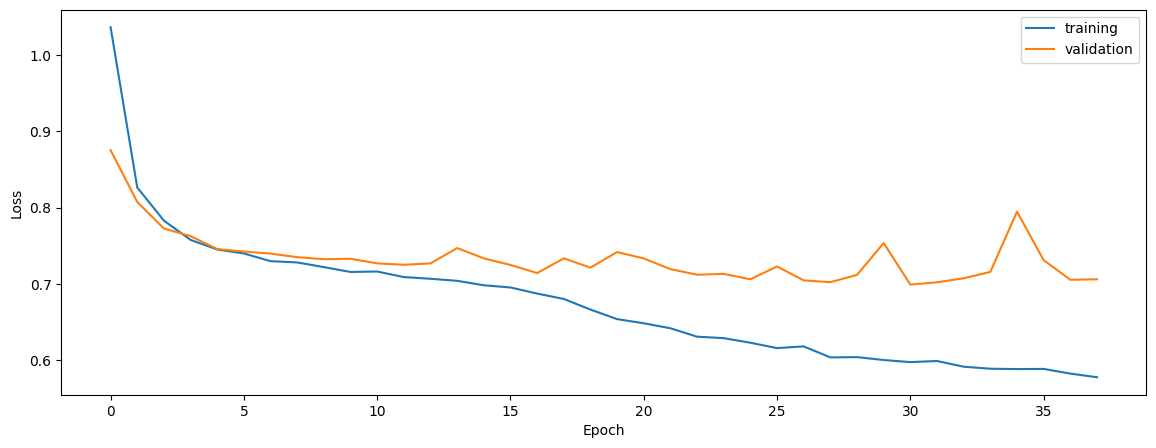

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.7507965883787018


0.7072199187568644


0.6985638270769186


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.722453199391226


0.6761976465811135


0.6852460534234526


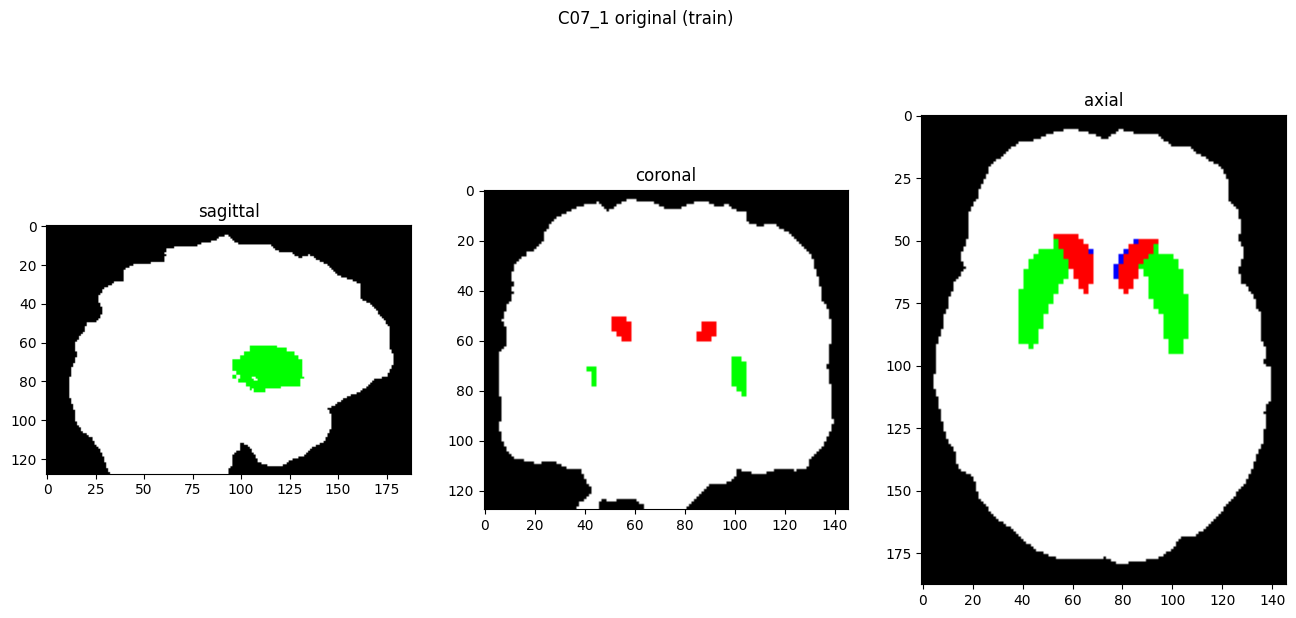

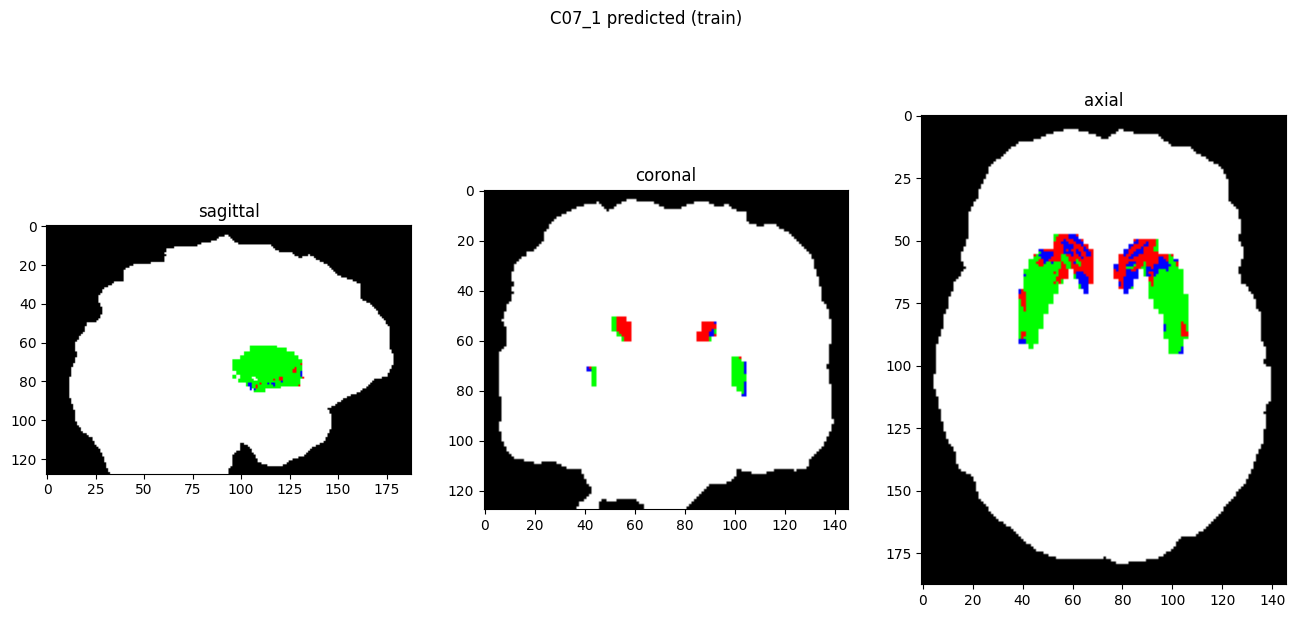

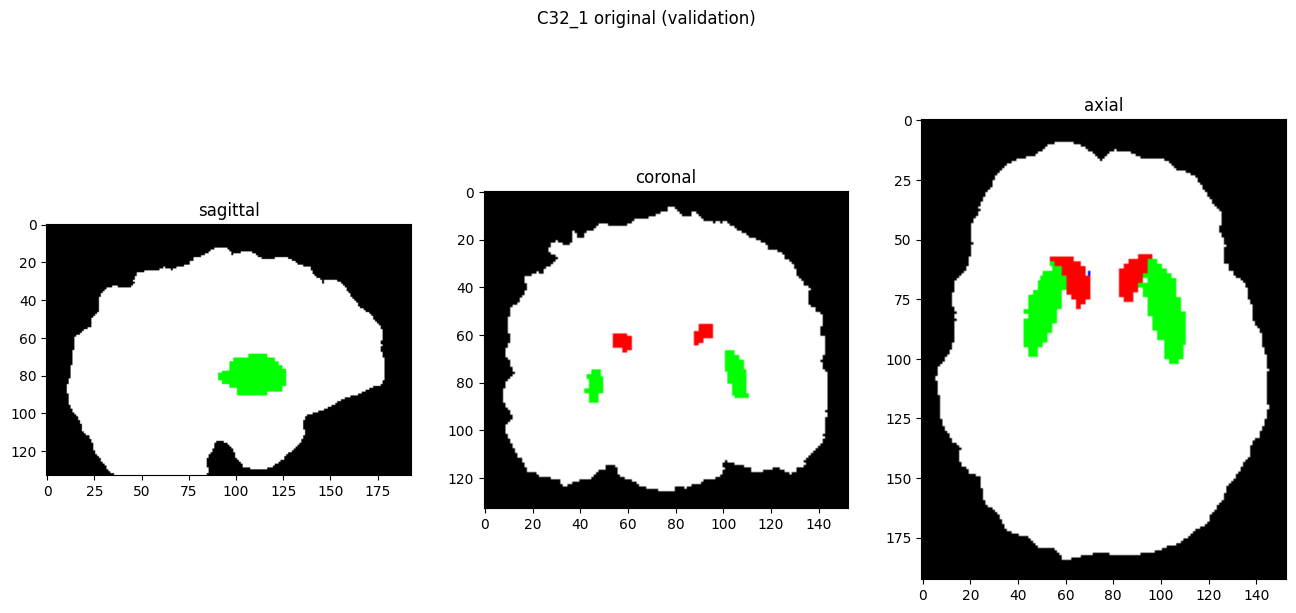

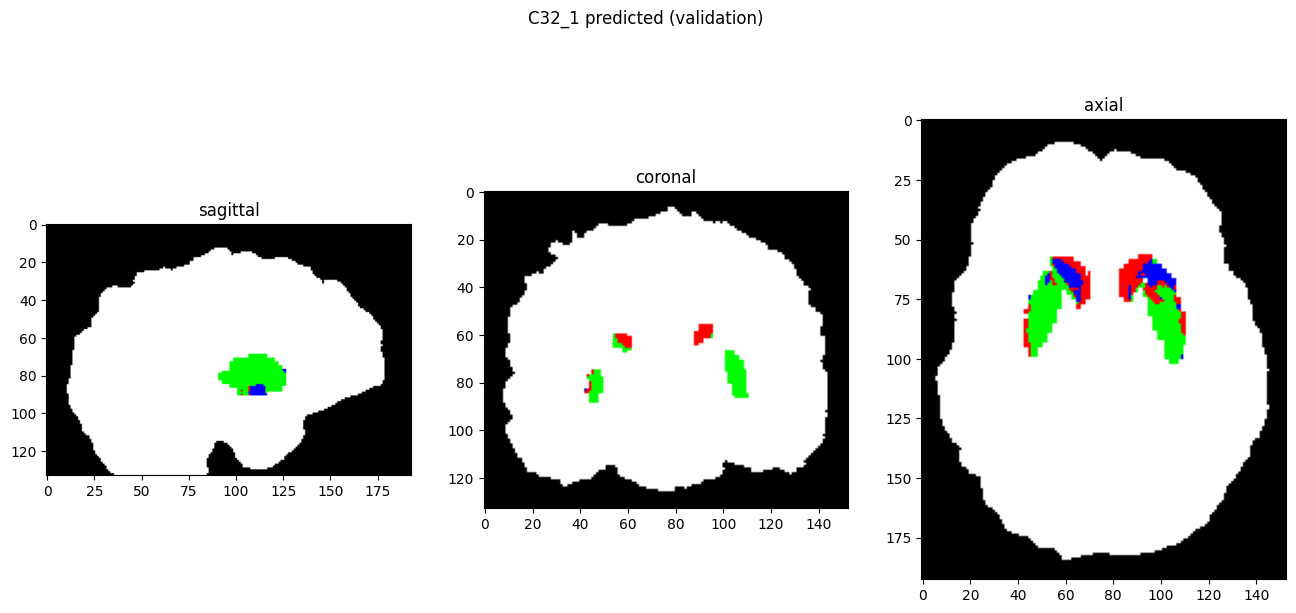

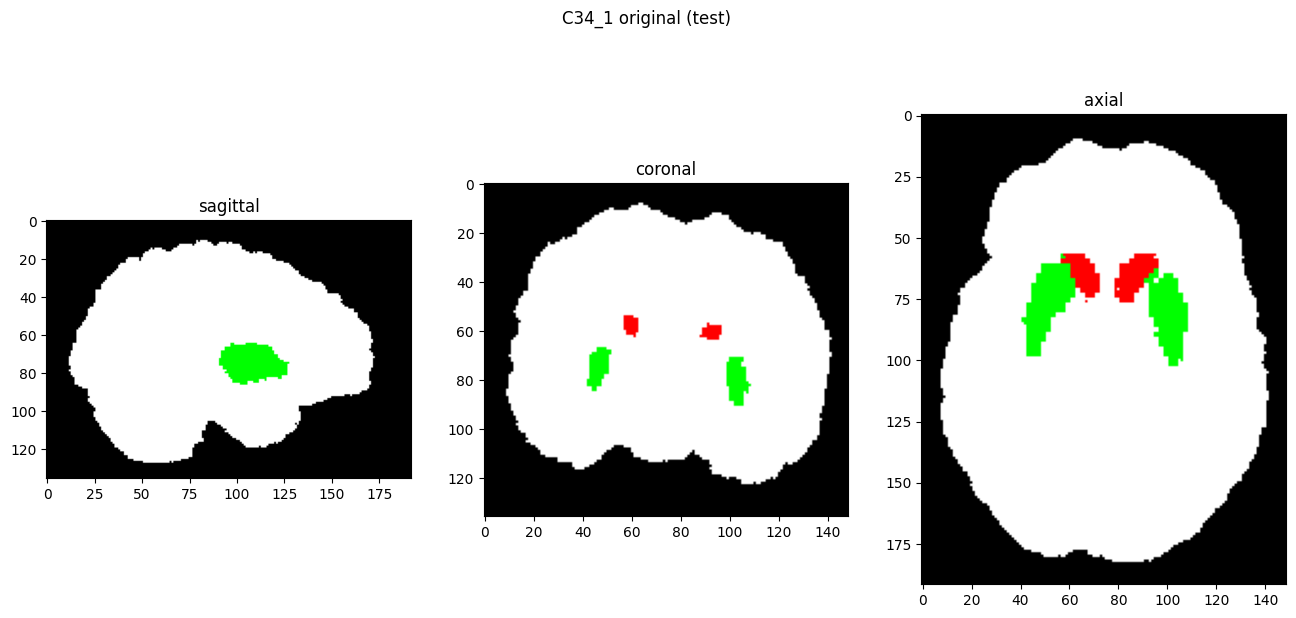

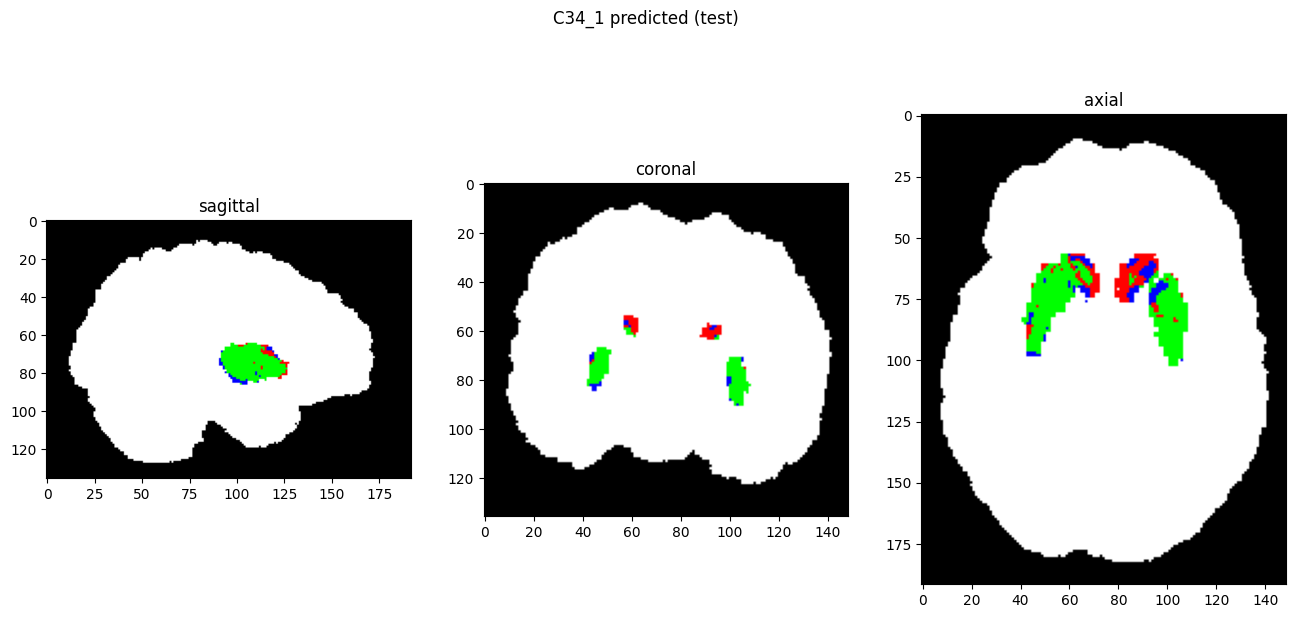

In [9]:
showResults(model, gen, threshold=0)